# REP2_Team7_MiniProject
Team 7 
Lex Tan Pengqin (U2322095L)
Tan Yu Xiu (U2322532B)
Lim Jun Shawn (U2320477A)

## Kaggle - Melbourne Housing Dataset
Dataset Link: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot/data
The dataset has 13580 columns and 21 rows, and contains data on the price, features of the estate,

## Problem Statement
This project will use regression techniques to predict the trend of housing prices in different estates in Melbourne. Additionally, we will analyze the significance of chosen variables in determining the price, to enhance the accuracy of the predictive model.
Below are our guiding questions:
1. Which features have the highest impact on price based on feature importance~~from a Random Forest model~~?
2. How has the price trend varied across different regions over time, and can we identify emerging high-value areas?
3. Which suburbs have the most competitive real estate markets based on property count, sales method, and price trends?

#### Response Variables
Importantly, we have chosen our indicators of real estate popularity (Response Variables) as Price.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.model_selection import FeatureImportances

### Importing dataset

In [3]:
housingdata = pd.read_csv('melb_data.csv')
# print(educationdata.head())
# print(educationdata.shape)
print(housingdata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         13580 non-null  object 
 1   Address        13580 non-null  object 
 2   Rooms          13580 non-null  int64  
 3   Type           13580 non-null  object 
 4   Price          13580 non-null  float64
 5   Method         13580 non-null  object 
 6   SellerG        13580 non-null  object 
 7   Date           13580 non-null  object 
 8   Distance       13580 non-null  float64
 9   Postcode       13580 non-null  float64
 10  Bedroom2       13580 non-null  float64
 11  Bathroom       13580 non-null  float64
 12  Car            13518 non-null  float64
 13  Landsize       13580 non-null  float64
 14  BuildingArea   7130 non-null   float64
 15  YearBuilt      8205 non-null   float64
 16  CouncilArea    12211 non-null  object 
 17  Lattitude      13580 non-null  float64
 18  Longti

Some of our observations:
- There is a good balance between the number of numerical (Dtype = int64/float64) and categorical (Dtype = object) features, allowing for deeper analysis.

In [4]:
print(housingdata.describe())

              Rooms         Price      Distance      Postcode      Bedroom2  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776   3105.301915      2.914728   
std        0.955748  6.393107e+05      5.868725     90.676964      0.965921   
min        1.000000  8.500000e+04      0.000000   3000.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000   3044.000000      2.000000   
50%        3.000000  9.030000e+05      9.200000   3084.000000      3.000000   
75%        3.000000  1.330000e+06     13.000000   3148.000000      3.000000   
max       10.000000  9.000000e+06     48.100000   3977.000000     20.000000   

           Bathroom           Car       Landsize  BuildingArea    YearBuilt  \
count  13580.000000  13518.000000   13580.000000   7130.000000  8205.000000   
mean       1.534242      1.610075     558.416127    151.967650  1964.684217   
std        0.691712      0.962634    3990.669241   

## Exploratory Data Analysis (EDA)
1. Categorizing Variables
2. Data Processing
3. Analysis of Respose Variable Price
4. Analysis of Numerical Predictor Variables
5. Analysis of Categorical Predictor Variables

### 1. Categorizing Variables

In [5]:
# Identify numerical and categorical columns using select_dtypes
numerical = housingdata.select_dtypes(include=[np.number]).columns.tolist()
categorical = housingdata.select_dtypes(include=['object', 'category']).columns.tolist()

# Convert object type columns to category
housingdata[categorical] = housingdata[categorical].astype('category')

print("Numeric features:")
print(numerical)
print()
print("Categorical features:")
print(categorical)

Numeric features:
['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Lattitude', 'Longtitude', 'Propertycount']

Categorical features:
['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


### 2. Data Processing

#### 2a. Checking for, and handling, NULL values

In [6]:
print(housingdata.isnull().sum())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64


Before deciding whether to drop or impute columns with missing values, it’s useful to assess their relative importance in predicting our response variable Price.

By training a decision tree regressor and visualizing feature importance, we can prioritize features that contribute significantly to predicting Price, and confidently remove those with low predictive value and high nullity.

This approach helps us simplify the model without sacrificing accuracy, and ensures we only invest effort in imputing values that matter.

**NOTE:** This will be a much dumbed-down approach of visualizing feature importance as compared to the Random Forest model we will use later, and is only essential for imputing NULL values.

(https://www.kaggle.com/code/residentmario/simple-techniques-for-missing-data-imputation#Data-missing-at-random-and-not-at-random)
(https://medium.com/@aaryanohekar277/what-is-the-difference-between-a-decision-tree-classifier-and-a-decision-tree-regressor-36641bd6559c)


**Decision Tree Regressor**

FeatureImportances(ax=<Axes: >,
                   estimator=DecisionTreeRegressor(random_state=42))

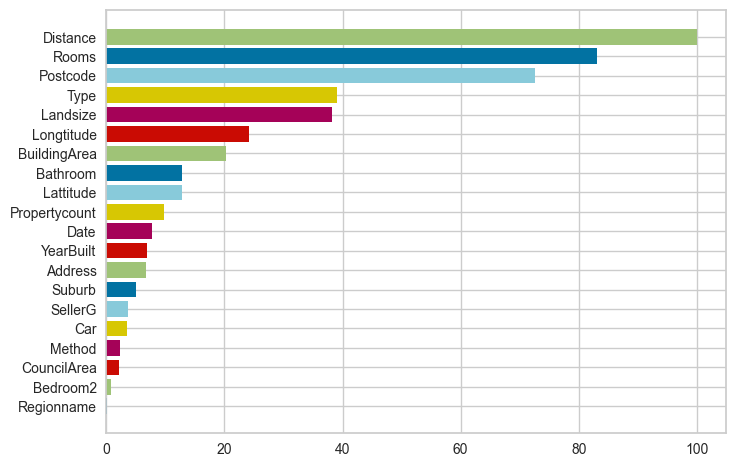

In [7]:
encoder = OrdinalEncoder()
housingdata[categorical] = encoder.fit_transform(housingdata[categorical].astype(str))

X1 = housingdata.drop(columns=["Price"])  # Features
y1= housingdata["Price"]  # Target


model1 = DecisionTreeRegressor(random_state=42)
viz1 = FeatureImportances(model1)
viz1.fit(X1, y1)

##### Imputing
https://medium.com/@ajayverma23/data-imputation-a-comprehensive-guide-to-handling-missing-values-b5c7d11c3488


#### Handling 'Car' NULL values
Since the number of NULL entries in Car is only about (62/13580) * 100 = 0.46% of the total number of rows, and its relative importance in predicting Price is low, we opt to drop these rows. This approach reduces preprocessing complexity without sacrificing valuable information for our analysis.

In [8]:
# drop rows accordingly 
housingdata = housingdata.dropna(subset=['Car'])

#### Handling 'BuildingArea' NULL values
Since the number of NULL entries in BuildingArea is about (6450/13580) * 100 = 47.5% of the total number of rows, which is significant, and its relative importance in predicting Price is moderate, we will impute the missing values using the median, grouped by Suburb, Rooms, and Type. This is because building area typically scales with number of rooms and depends on housing type, and suburbs offer spatial consistency.

In [9]:
# Impute BuildingArea based on median within Suburb + Distance + Rooms
housingdata['BuildingArea'] = housingdata.groupby(['Suburb', 'Rooms', 'Type'])['BuildingArea'].transform(
    lambda x: x.fillna(x.median())
)

c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarnin

#### Handling 'YearBuilt' NULL values
Since the number of NULL entries in YearBuilt is about (5375/13580) * 100 = 39.6% of the total number of rows, which is moderate, and its relative importance in predicting Price is also moderate, we will impute the missing values using the median, grouped by Suburb and Type. This leverages contextual property characteristics to estimate construction year more accurately.

In [10]:
# Impute YearBuilt based on Suburb + Type
housingdata['YearBuilt'] = housingdata.groupby(['Suburb', 'Type'])['YearBuilt'].transform(
    lambda x: x.fillna(x.median())
)

c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\GitHub\dsaiMiniProject\.env\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarnin

#### Handling 'CouncilArea' NULL values
Since the number of NULL entries in CouncilArea is about (1369/13580) * 100 = 10.1% of the total number of rows, which is moderate. Given that CouncilArea has moderate feature importance in predicting Price, we will impute the missing values using the mode, grouped by Suburb, as council areas typically align with geographic boundaries.

In [11]:
# Impute CouncilArea (categorical) based on Suburb
housingdata['CouncilArea'] = housingdata.groupby('Suburb')['CouncilArea'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
)

Checking the null values again

In [12]:
print(housingdata.isnull().sum())

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2           0
Bathroom           0
Car                0
Landsize           0
BuildingArea     440
YearBuilt         80
CouncilArea        0
Lattitude          0
Longtitude         0
Regionname         0
Propertycount      0
dtype: int64


Given that we still have a small proportion of NULL values left even after our imputing, we will choose to drop these rows.

In [13]:
housingdata = housingdata.dropna(subset=['BuildingArea'])
housingdata = housingdata.dropna(subset=['YearBuilt'])

In [14]:
print(housingdata.isnull().sum())

Suburb           0
Address          0
Rooms            0
Type             0
Price            0
Method           0
SellerG          0
Date             0
Distance         0
Postcode         0
Bedroom2         0
Bathroom         0
Car              0
Landsize         0
BuildingArea     0
YearBuilt        0
CouncilArea      0
Lattitude        0
Longtitude       0
Regionname       0
Propertycount    0
dtype: int64


After imputing, all the categorical rows have been converted to numerical rows, hence we have to convert them back. 

In [15]:
housingdata[categorical] = housingdata[categorical].astype('object')

# Check the updated dtypes
print(housingdata.dtypes)

Suburb            object
Address           object
Rooms              int64
Type              object
Price            float64
Method            object
SellerG           object
Date              object
Distance         float64
Postcode         float64
Bedroom2         float64
Bathroom         float64
Car              float64
Landsize         float64
BuildingArea     float64
YearBuilt        float64
CouncilArea       object
Lattitude        float64
Longtitude       float64
Regionname        object
Propertycount    float64
dtype: object


#### 2b. Checking for, and removing, duplicate values

In [16]:
print(housingdata.duplicated().sum())

0


Since there are no duplicate values, we will continue with our analysis.

### 3. Analysis of Response Variable Price

In [17]:
price = housingdata["Price"]
price.describe()

count    1.306600e+04
mean     1.077267e+06
std      6.404485e+05
min      8.500000e+04
25%      6.500000e+05
50%      9.035000e+05
75%      1.330000e+06
max      9.000000e+06
Name: Price, dtype: float64

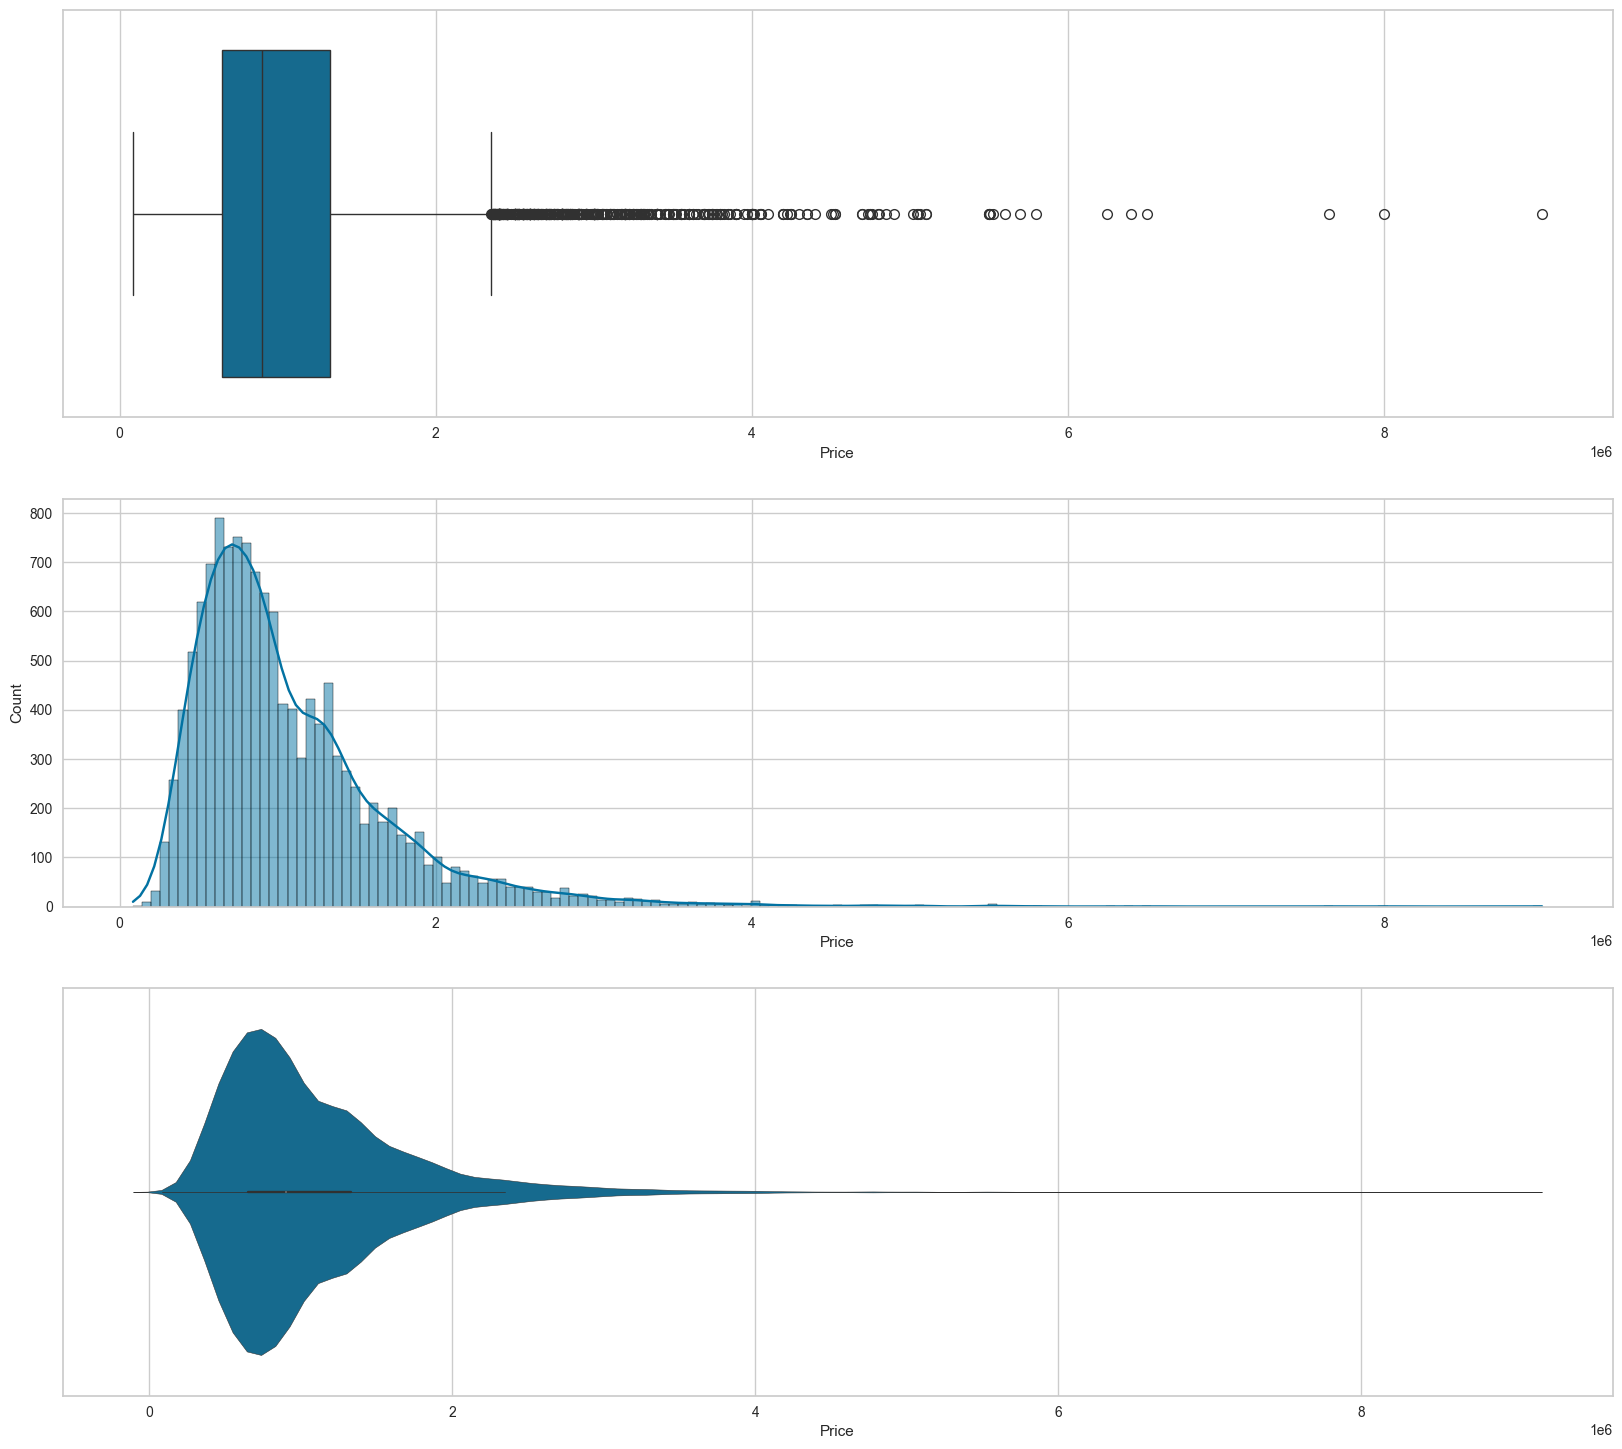

In [18]:
f, axes = plt.subplots(3,1, figsize=(20,18)) 

sb.boxplot(data = price, orient = 'h', ax=axes[0]);
sb.histplot(data = price, ax=axes[1], kde=True);
sb.violinplot(data = price, orient = 'h', ax=axes[2]);


### 4. Univariate Analysis of Numerical Predictor Variables
4.1 Box, Histogram, Violin Plots
4.2 Correlation Matrix for Numerical Features with Price
4.3 Scatter Plots for Numerical Features against Price

In [19]:
numerical_without_price = housingdata[numerical].drop(columns=["Price"])
numerical_without_price.describe()

Rooms      Distance      Postcode      Bedroom2      Bathroom  \
count  13066.000000  13066.000000  13066.000000  13066.000000  13066.000000   
mean       2.933415     10.048117   3103.903260      2.909230      1.531073   
std        0.932472      5.730516     87.174441      0.934042      0.689314   
min        1.000000      0.000000   3000.000000      0.000000      0.000000   
25%        2.000000      6.100000   3044.000000      2.000000      1.000000   
50%        3.000000      9.200000   3084.000000      3.000000      1.000000   
75%        3.000000     13.000000   3147.000000      3.000000      2.000000   
max        8.000000     47.400000   3977.000000      9.000000      8.000000   

                Car       Landsize  BuildingArea     YearBuilt     Lattitude  \
count  13066.000000   13066.000000  13066.000000  13066.000000  13066.000000   
mean       1.609597     546.817848    139.664890   1962.001913    -37.808792   
std        0.963456    3978.724641    103.700871     34.130073      0.078424   
min        0.000000       0.000000      0.000000   1196.000000    -38.182550   
25%        1.000000     177.250000     94.000000   1940.000000    -37.856490   
50%        2.000000     444.000000    124.500000   1965.000000    -37.802075   
75%        2.000000     650.000000    164.000000   1986.000000    -37.756293   
max       10.000000  433014.000000   6791.000000   2018.000000    -37.408530   

         Longtitude  Propertycount  
count  13066.000000   13066.000000  
mean     144.994105    7543.149089  
std        0.102292    4384.360761  
min      144.542370     389.000000  
25%      144.928700    4442.000000  
50%      144.999700    6567.000000  
75%      145.056880   10331.000000  
max      145.526350   21650.000000

### 5. Analysis of Categorical Variables
5.1 Distribution of each variable with a count plot\
5.2 Box Plot of categorical variable and price

To recap, the categorical variables of the dataset are ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname'].

Before we begin analysis of the categorical variables, let's undo the encoding performed earlier for the Decision Tree Regression so we can obtain the original string values. Let's take a look at the description of the categorical variables as well. 

In [20]:
housingdata[categorical] = encoder.inverse_transform(housingdata[categorical])
housingdata[categorical].describe().T

count unique                    top  freq
Suburb       13066    300              Reservoir   359
Address      13066  12874            28 Blair St     3
Type         13066      3                      h  9142
Method       13066      5                      S  8701
SellerG      13066    263                 Nelson  1532
Date         13066     58             27/05/2017   445
CouncilArea  13066     33                    nan  1252
Regionname   13066      8  Southern Metropolitan  4547

Additionally, let us perform frequency counts for each categorical variable.

In [21]:
print("\n=== Frequency Counts for Categorical Variables ===\n")
for col in categorical:
    print(f"--- {col} ---")
    print(housingdata[col].value_counts())
    print("\n")


=== Frequency Counts for Categorical Variables ===

--- Suburb ---
Suburb
Reservoir         359
Richmond          259
Bentleigh East    249
Preston           237
Brunswick         221
                 ... 
Whittlesea          1
Wallan              1
Campbellfield       1
Plumpton            1
Kooyong             1
Name: count, Length: 300, dtype: int64


--- Address ---
Address
28 Blair St       3
14 Arthur St      3
13 Robinson St    3
2 Bruce St        3
5 Margaret St     3
                 ..
20 Airds Rd       1
16 Benambra Dr    1
50 Caroline Dr    1
7 Dove Ct         1
129 Charles St    1
Name: count, Length: 12874, dtype: int64


--- Type ---
Type
h    9142
u    2903
t    1021
Name: count, dtype: int64


--- Method ---
Method
S     8701
SP    1634
PI    1509
VB    1134
SA      88
Name: count, dtype: int64


--- SellerG ---
SellerG
Nelson           1532
Jellis           1277
hockingstuart    1131
Barry             972
Ray               669
                 ... 
Area              

#### Analysis of 'Suburb' Variable

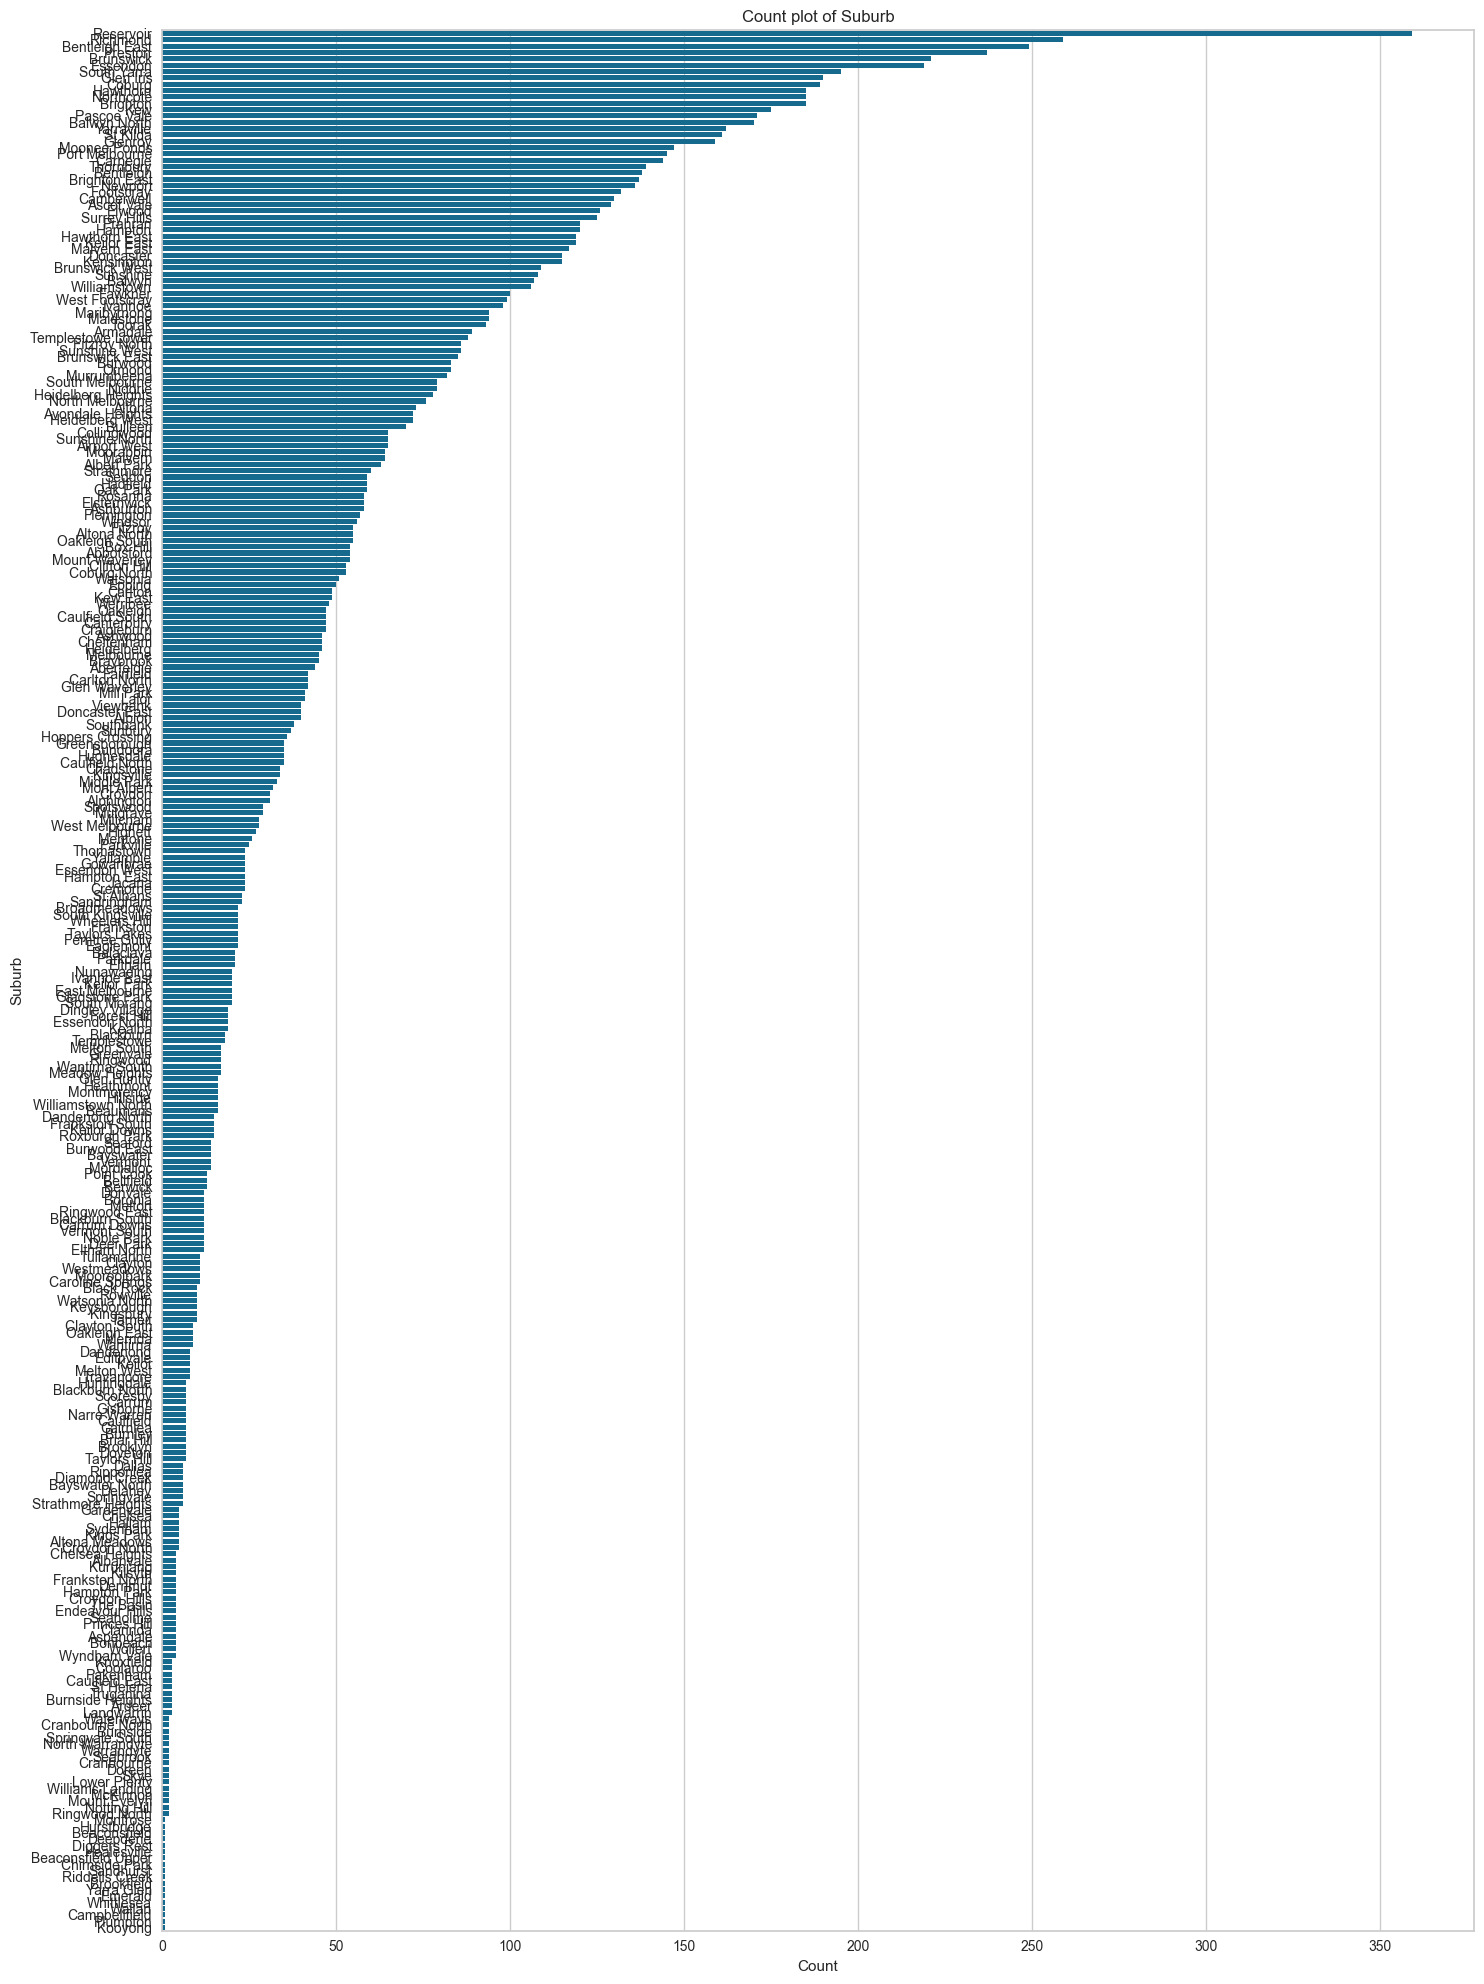

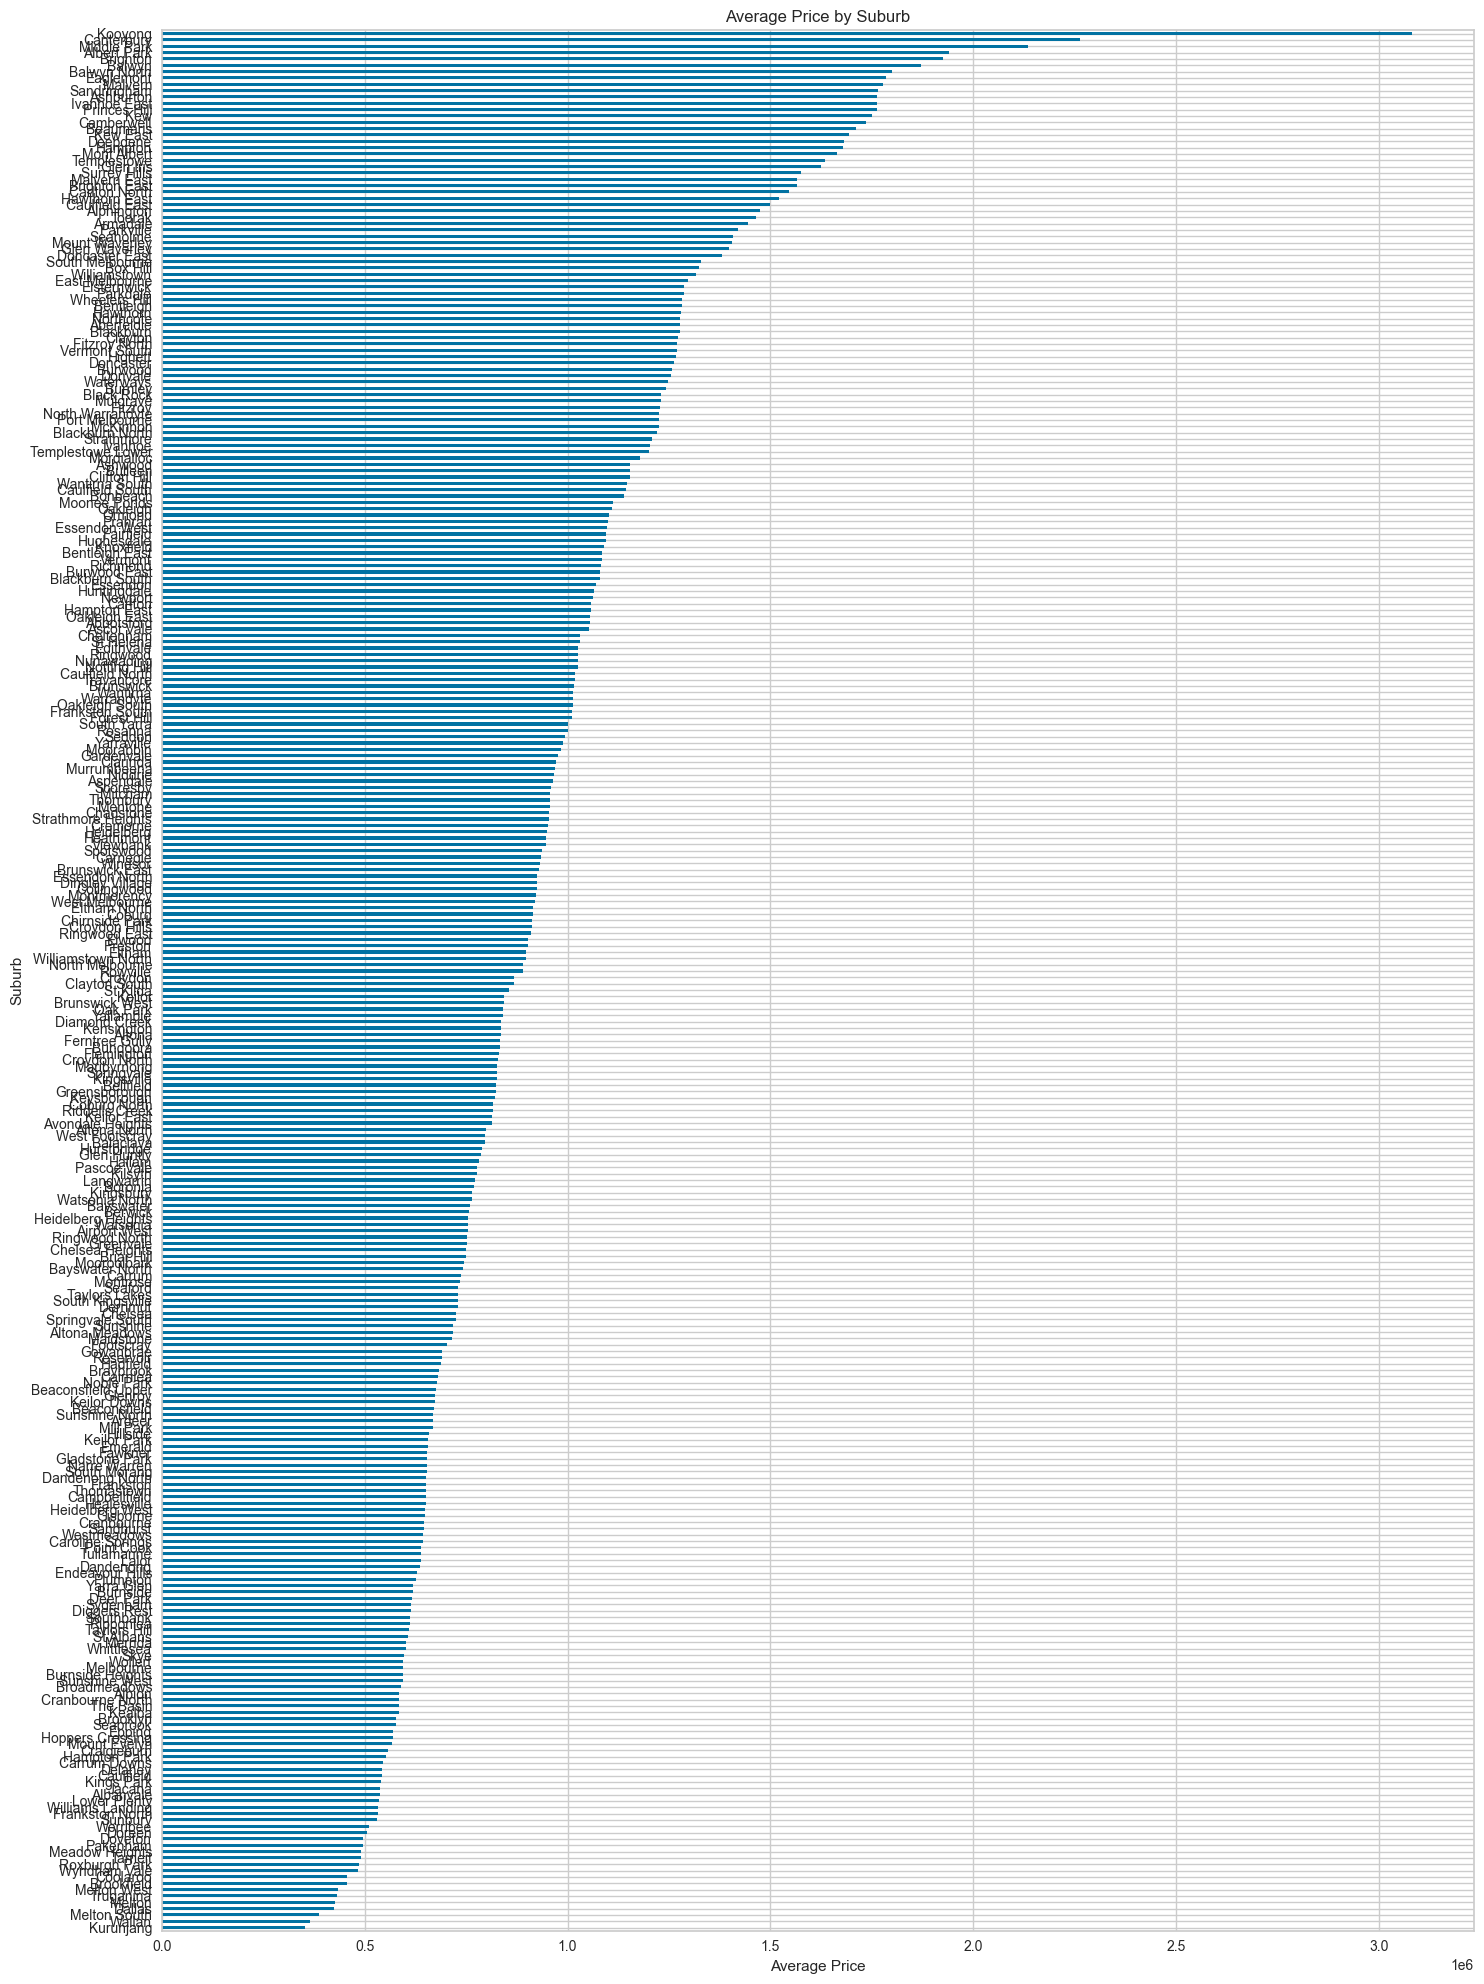

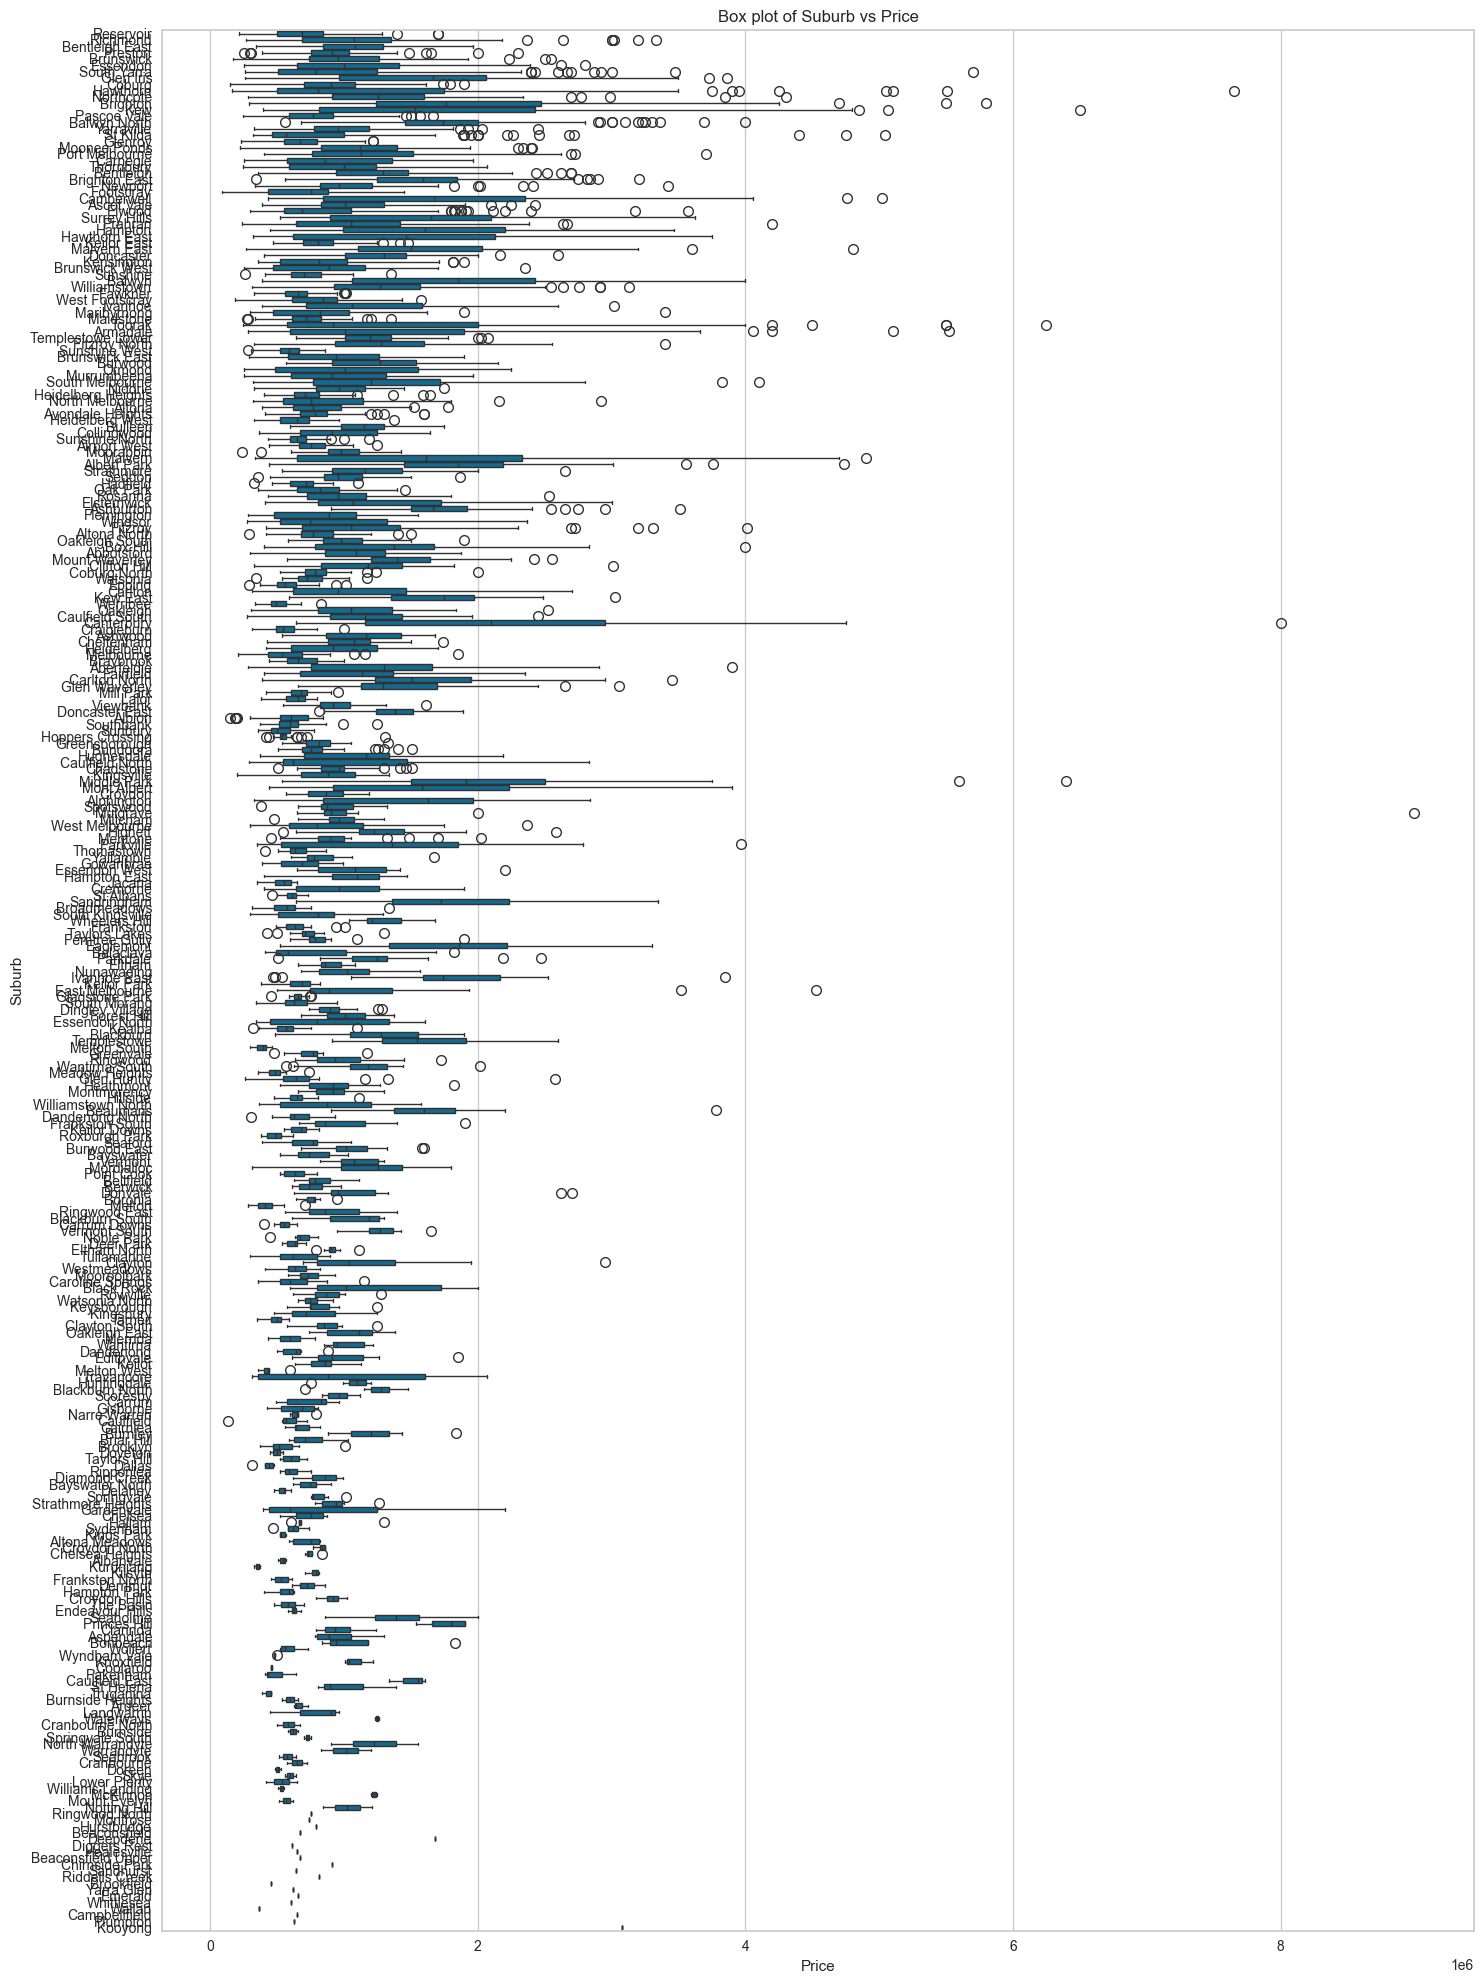

In [22]:
# Count plot for Suburb
plt.figure(figsize=(15, 20))
sb.countplot(data=housingdata, y='Suburb', order=housingdata['Suburb'].value_counts().index)
plt.title('Count plot of Suburb')
plt.xlabel('Count')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Average price bar plot for Suburb
# We'll compute the average price per suburb and plot it
avg_price = housingdata.groupby('Suburb')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15, 20))
avg_price.plot(kind='barh')
plt.title('Average Price by Suburb')
plt.xlabel('Average Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Suburb
plt.figure(figsize=(15, 20))
sb.boxplot(data=housingdata, y='Suburb', x='Price', order=housingdata['Suburb'].value_counts().index)
plt.title('Box plot of Suburb vs Price')
plt.xlabel('Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

There is

#### Analysis of 'Type' Variable

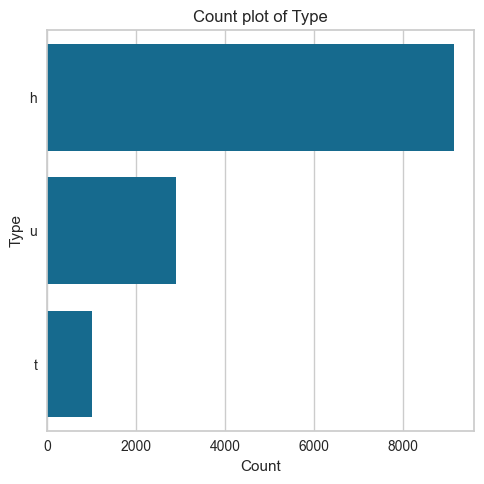

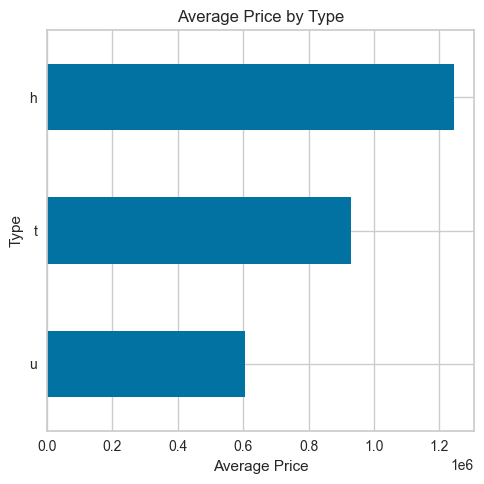

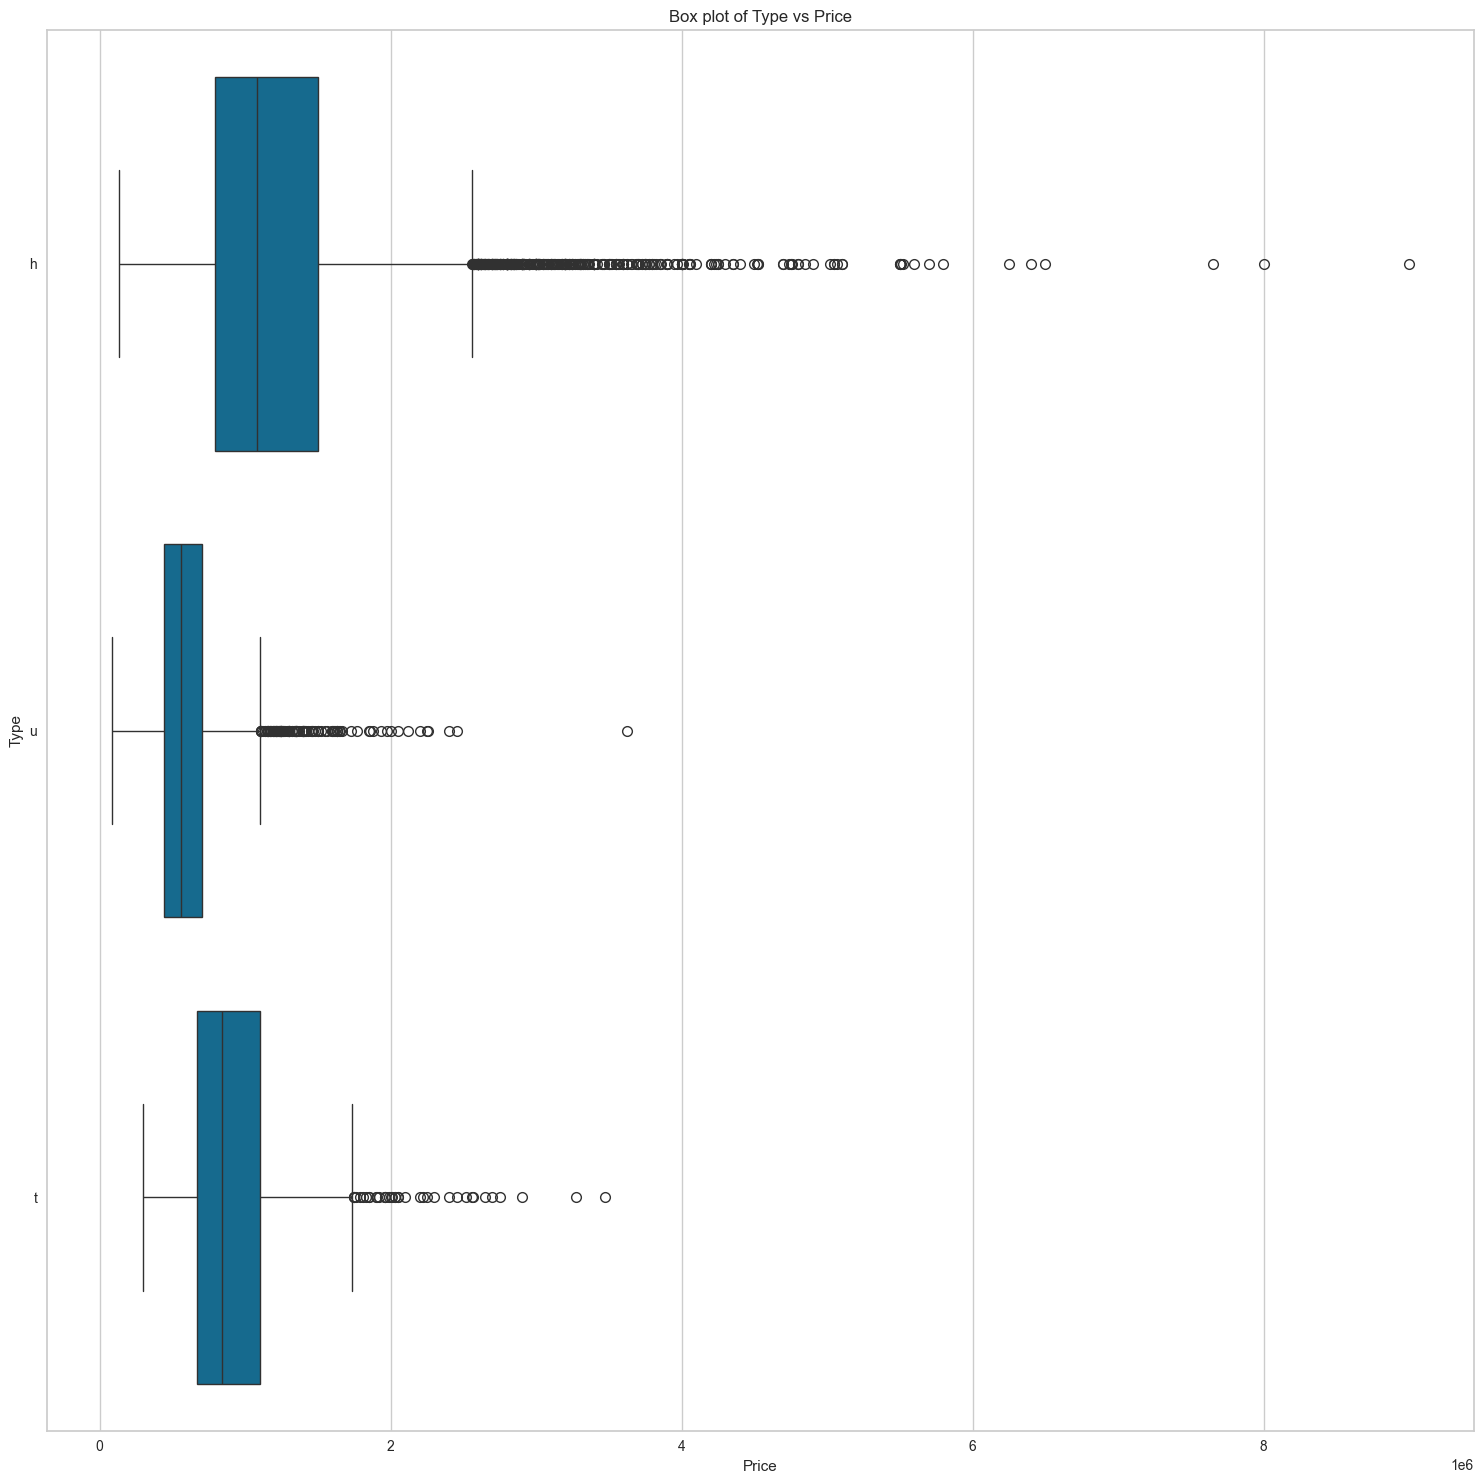

In [23]:
# Count plot for Type
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Type', order=housingdata['Type'].value_counts().index)
plt.title('Count plot of Type')
plt.xlabel('Count')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

# Average price bar plot for Type
# We'll compute the average price per Type and plot it
avg_price = housingdata.groupby('Type')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Type')
plt.xlabel('Average Price')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Type
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='Type', x='Price', order=housingdata['Type'].value_counts().index)
plt.title('Box plot of Type vs Price')
plt.xlabel('Price')
plt.ylabel('Type')
plt.tight_layout()
plt.show()

##### Analysis of 'Method' Variable

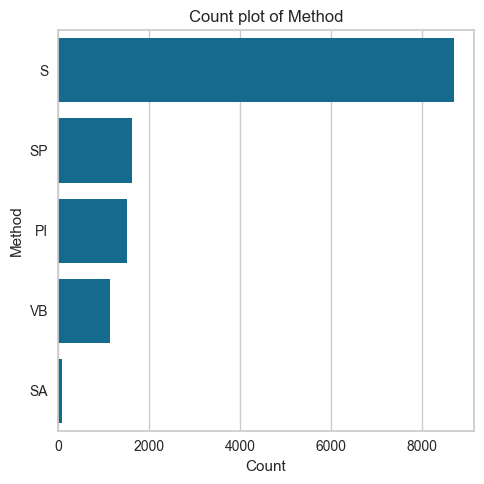

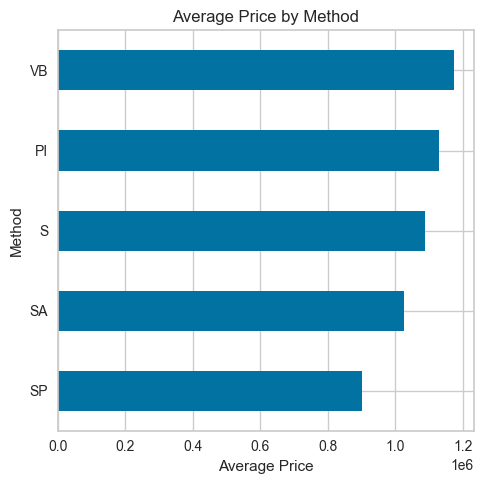

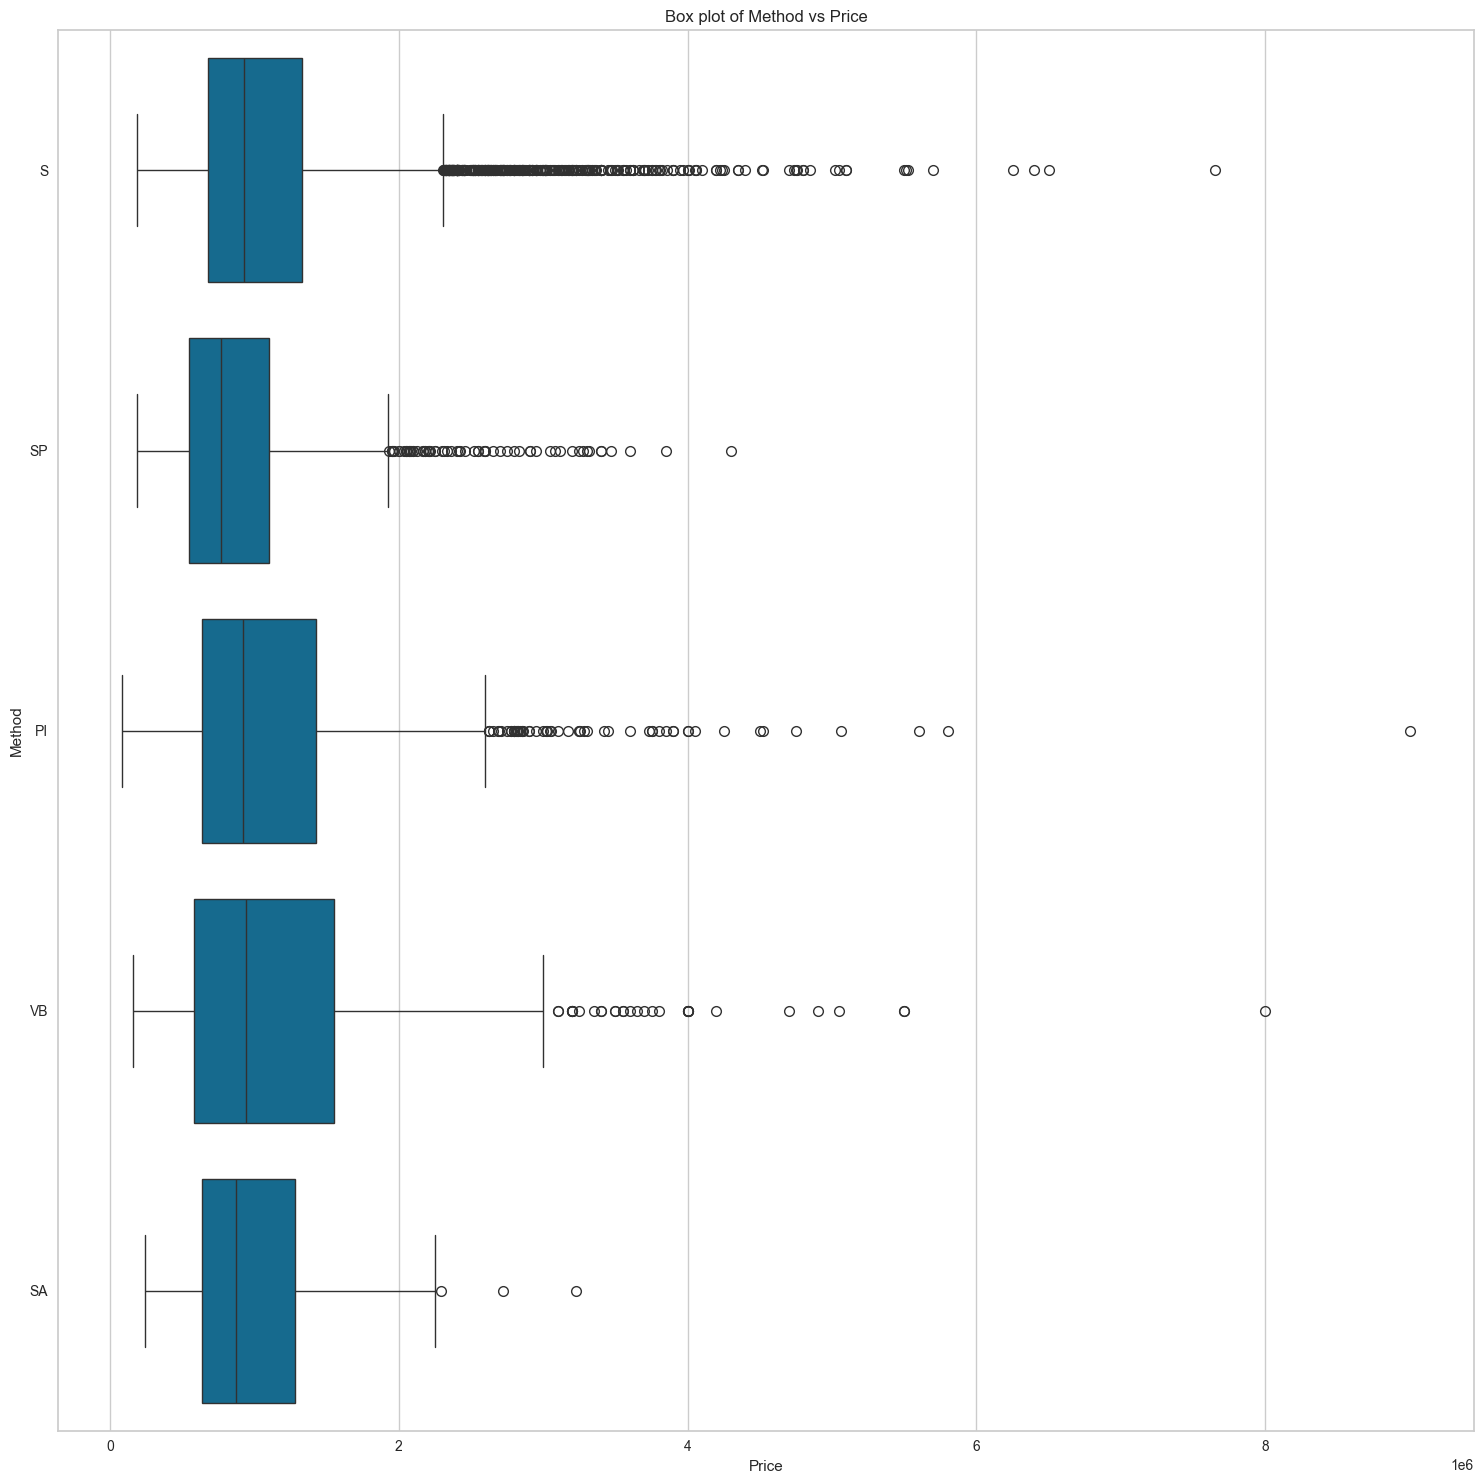

In [24]:
# Count plot for Method
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Method', order=housingdata['Method'].value_counts().index)
plt.title('Count plot of Method')
plt.xlabel('Count')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

# Average price bar plot for Method
# We'll compute the average price per Method and plot it
avg_price = housingdata.groupby('Method')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Method')
plt.xlabel('Average Price')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Method
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='Method', x='Price', order=housingdata['Method'].value_counts().index)
plt.title('Box plot of Method vs Price')
plt.xlabel('Price')
plt.ylabel('Method')
plt.tight_layout()
plt.show()

##### Analysis of 'SellerG' Variable

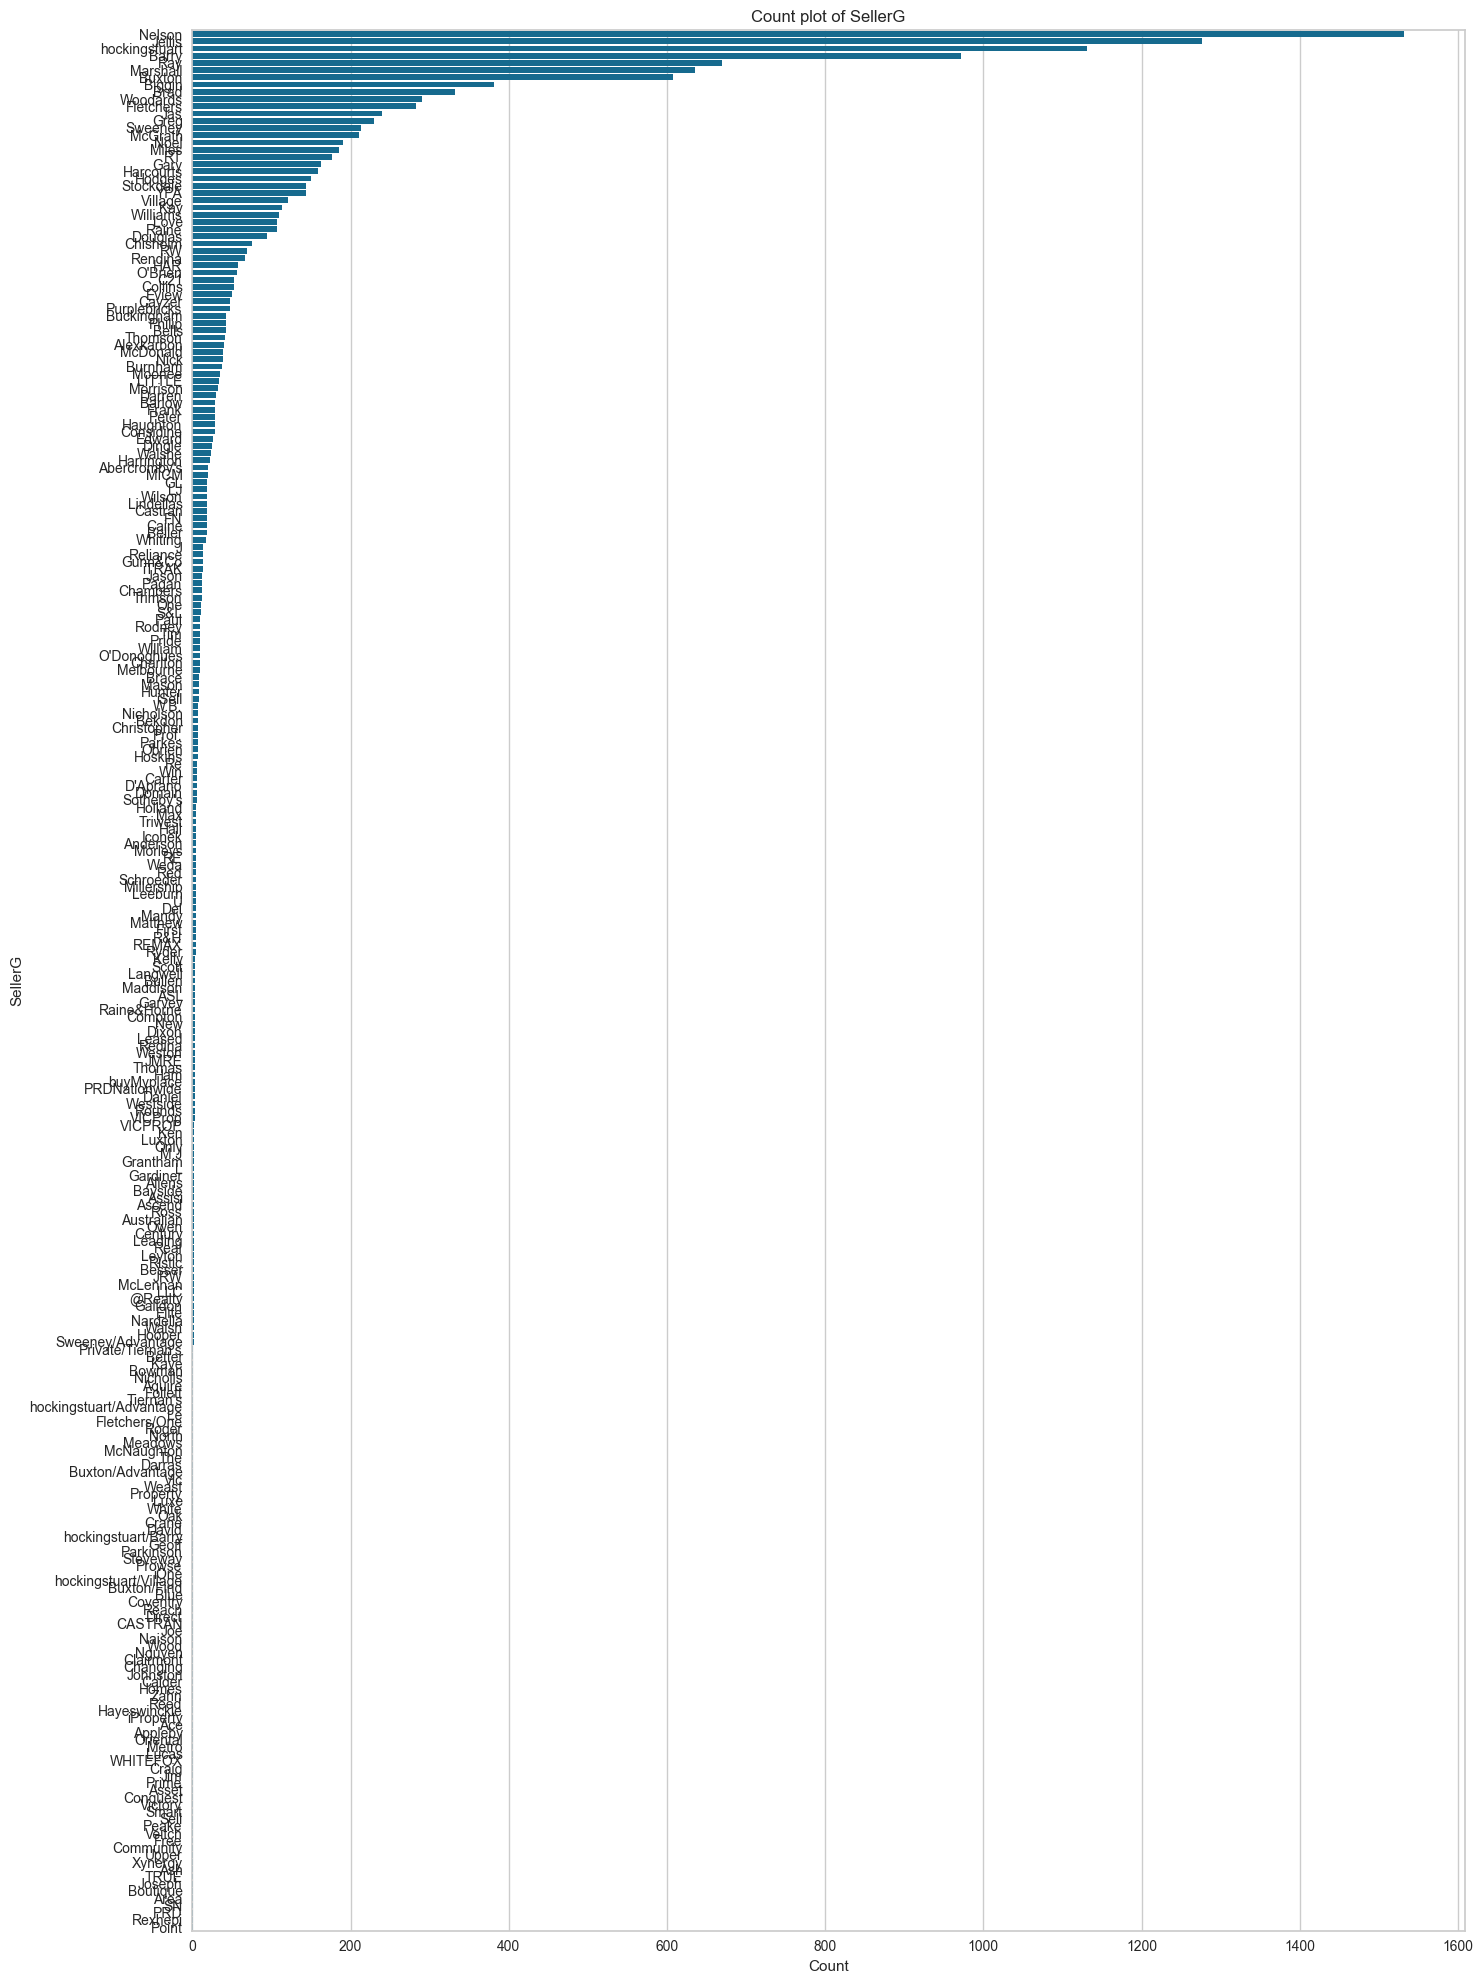

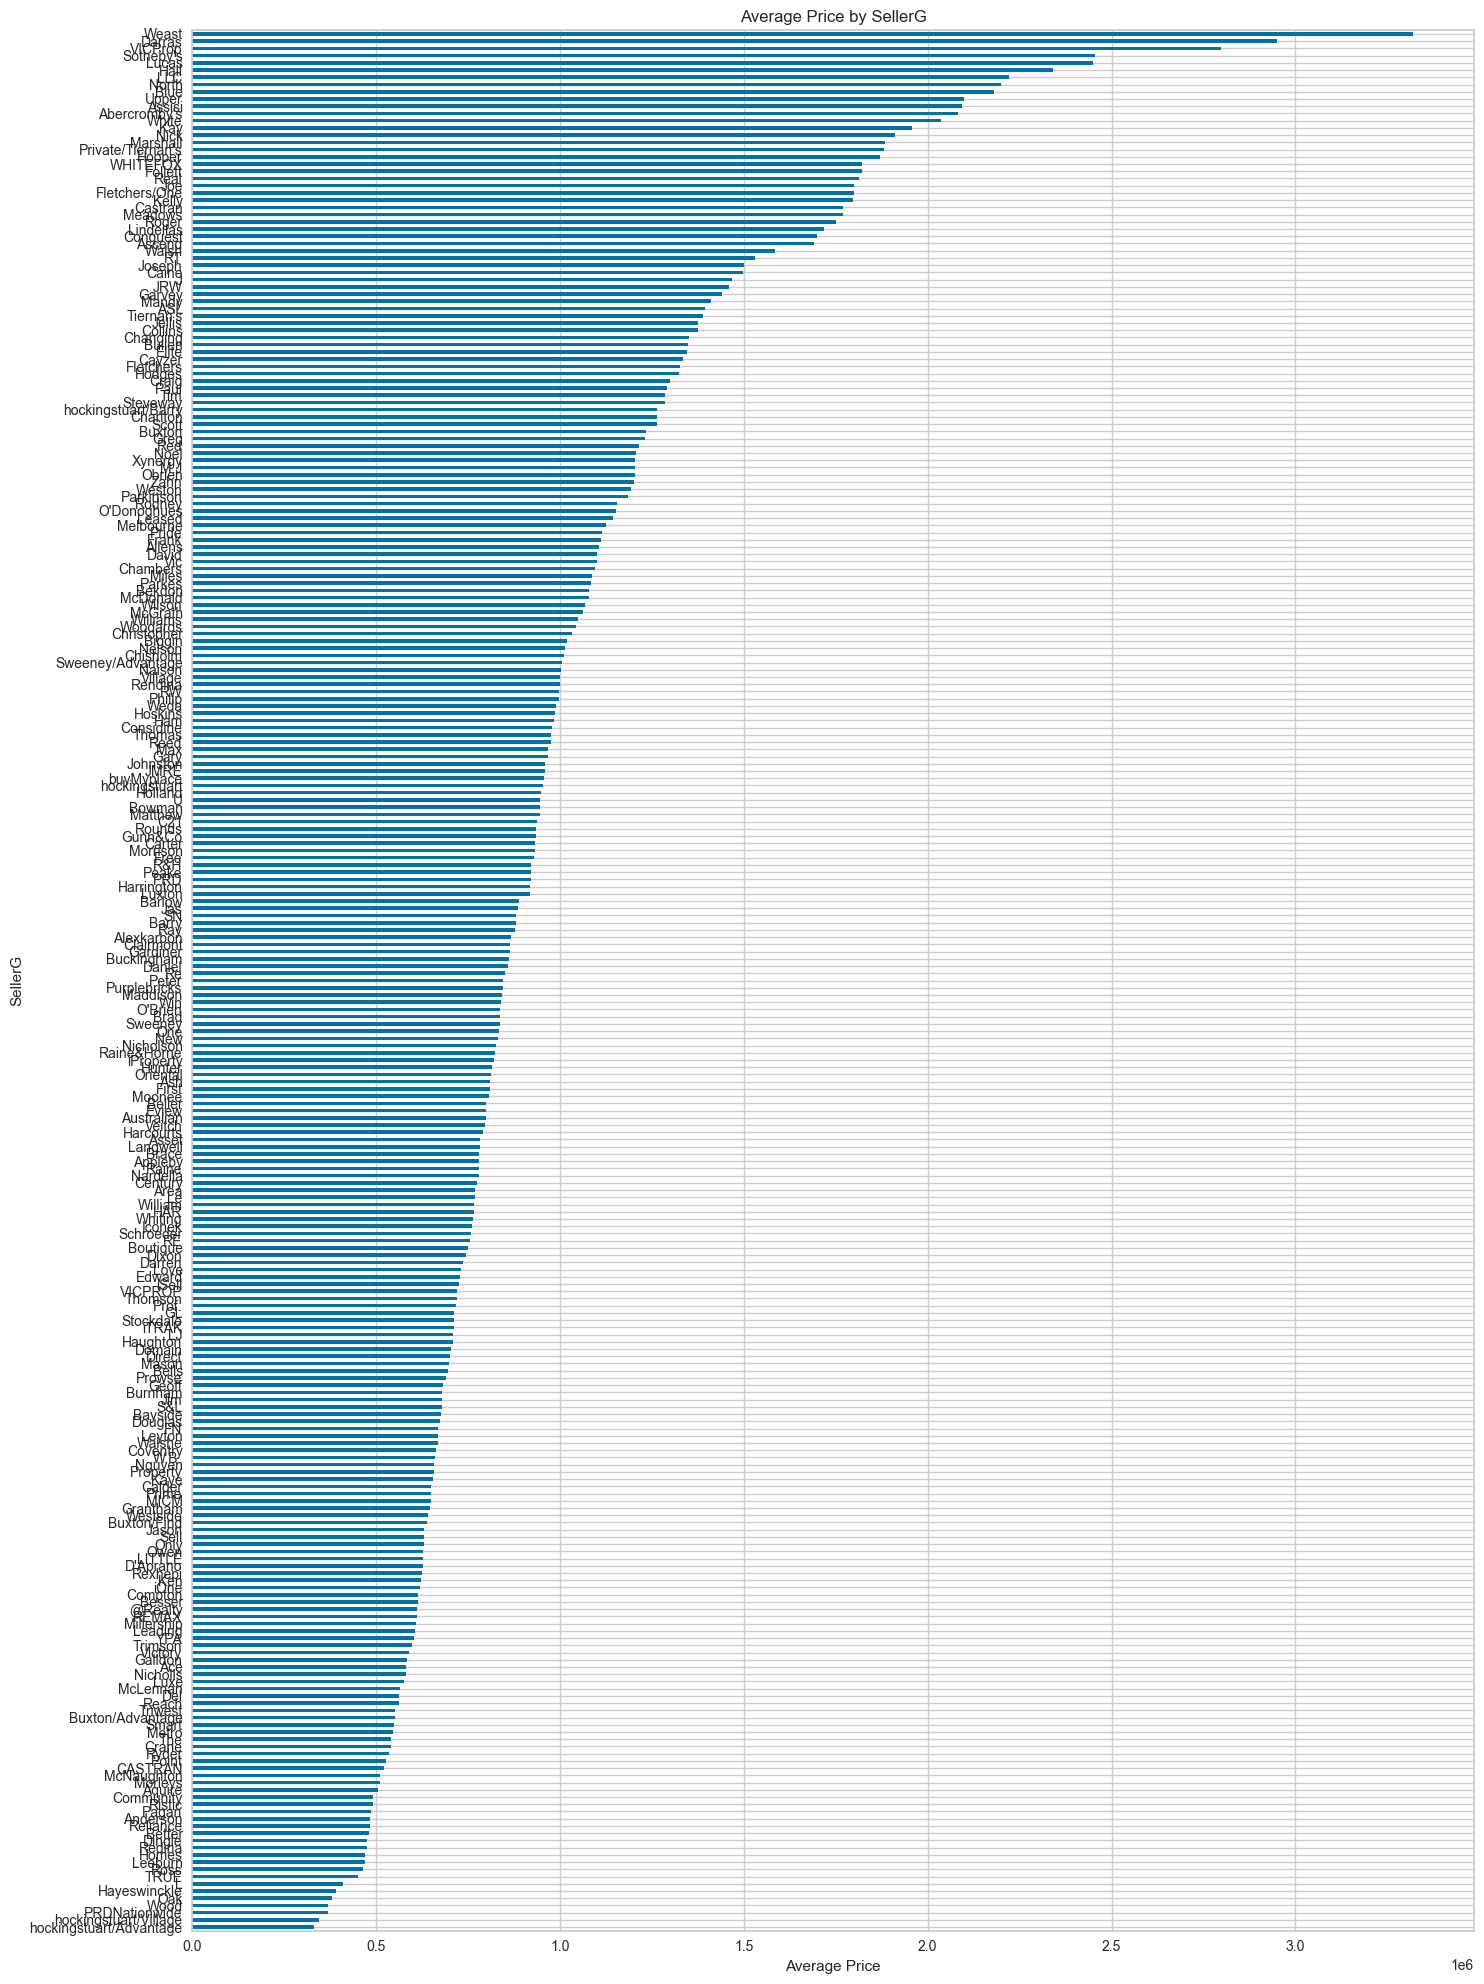

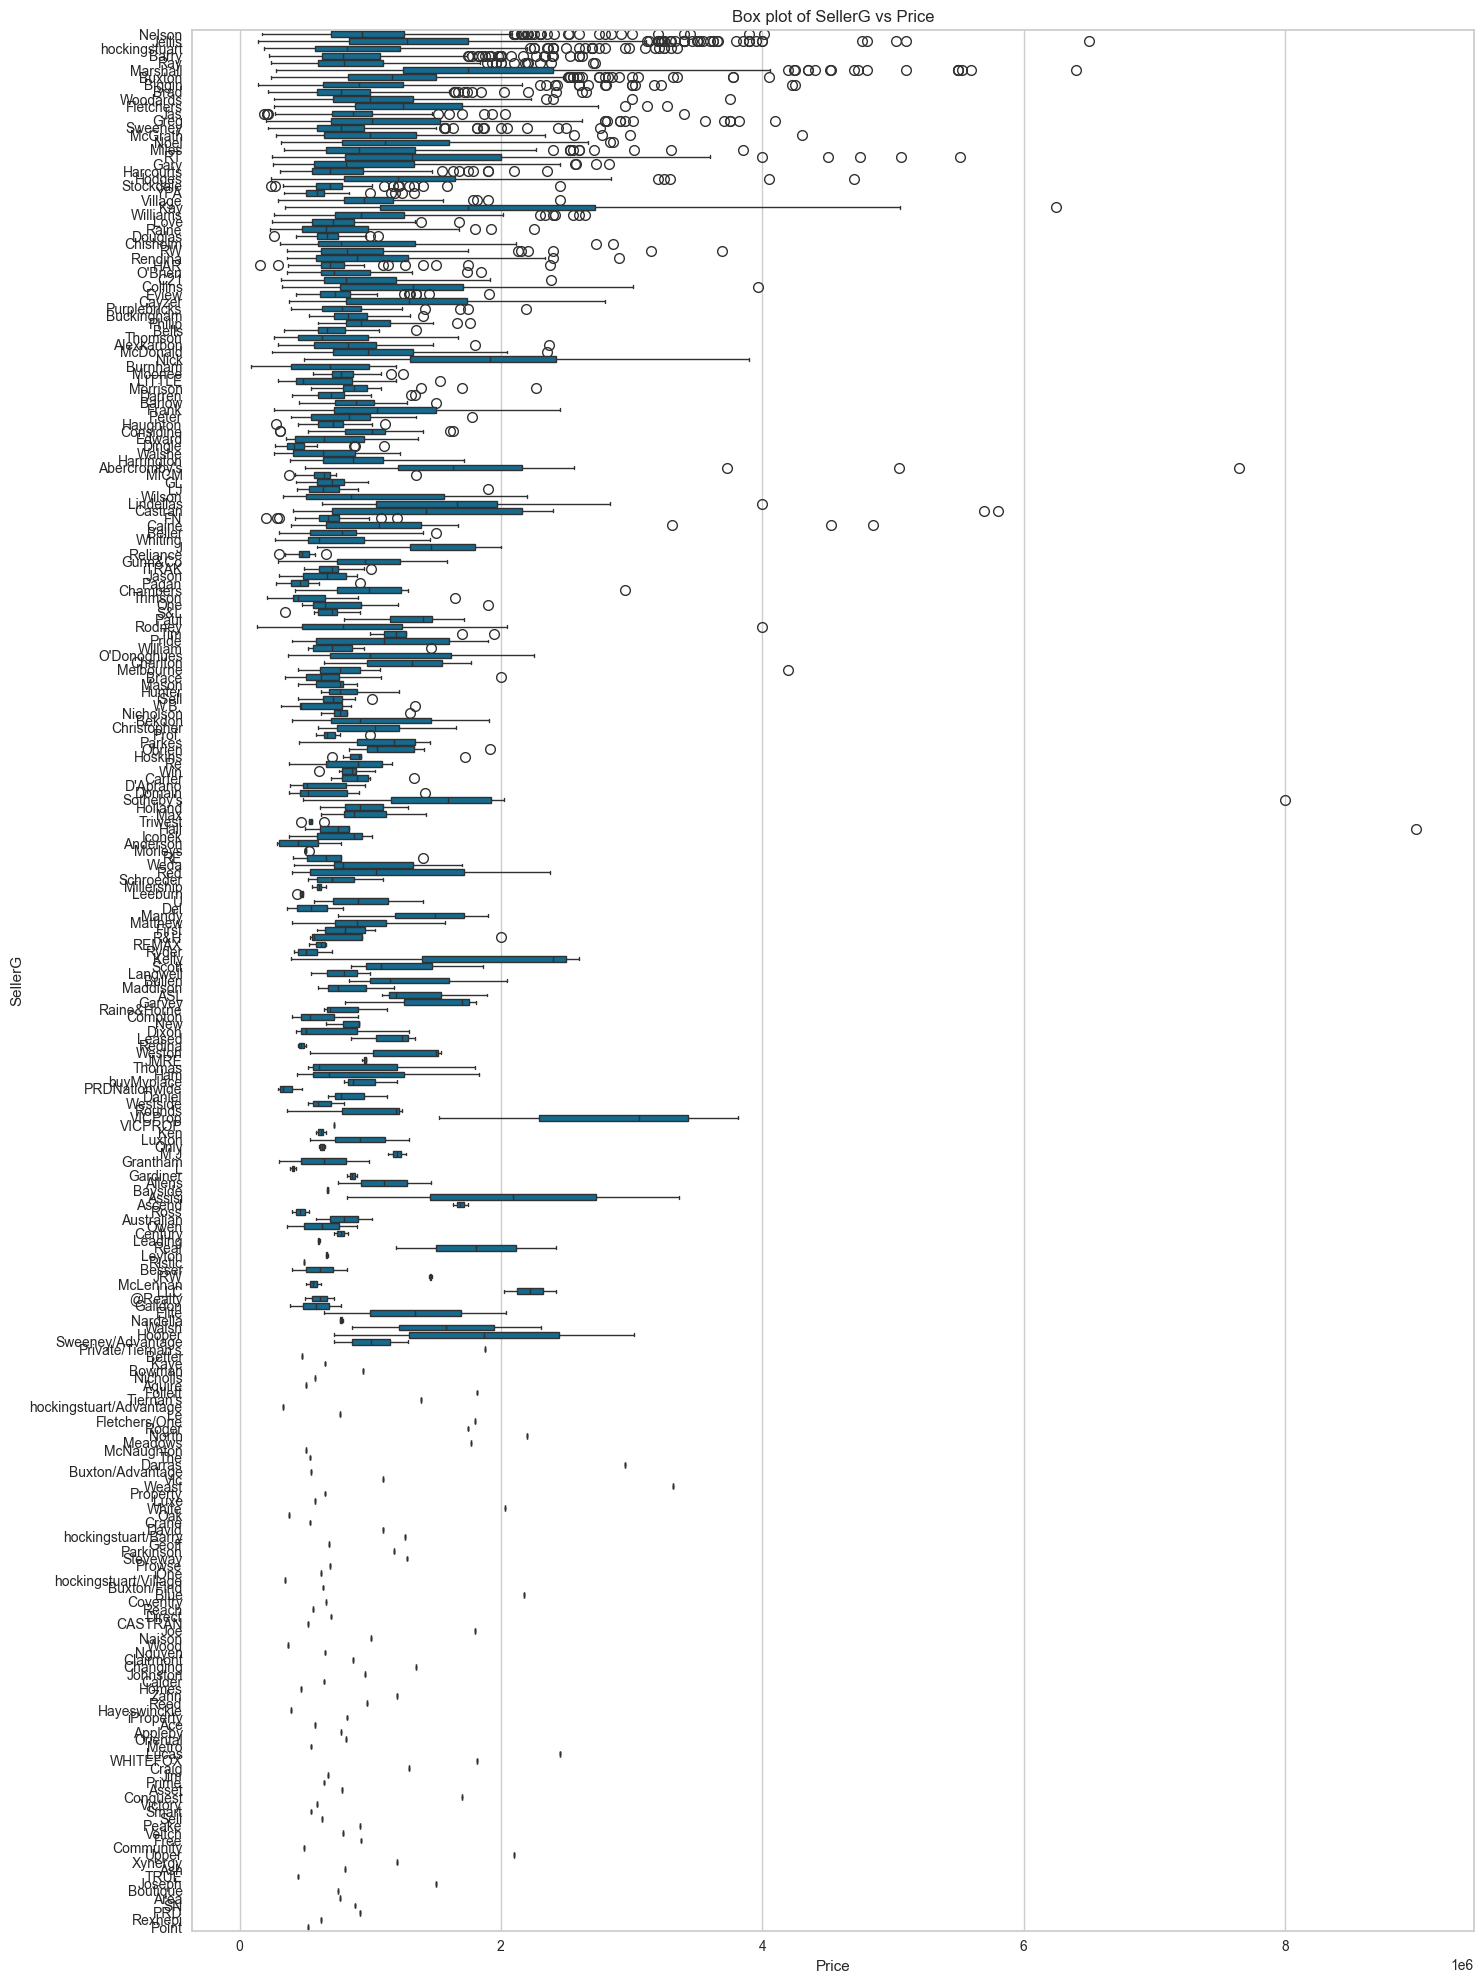

In [25]:
# Count plot for SellerG
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='SellerG', order=housingdata['SellerG'].value_counts().index)
plt.title('Count plot of SellerG')
plt.xlabel('Count')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Average price bar plot for SellerG
# We'll compute the average price per SellerG and plot it
avg_price = housingdata.groupby('SellerG')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by SellerG')
plt.xlabel('Average Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by SellerG
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='SellerG', x='Price', order=housingdata['SellerG'].value_counts().index)
plt.title('Box plot of SellerG vs Price')
plt.xlabel('Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

##### Analysis of 'Date' Variable

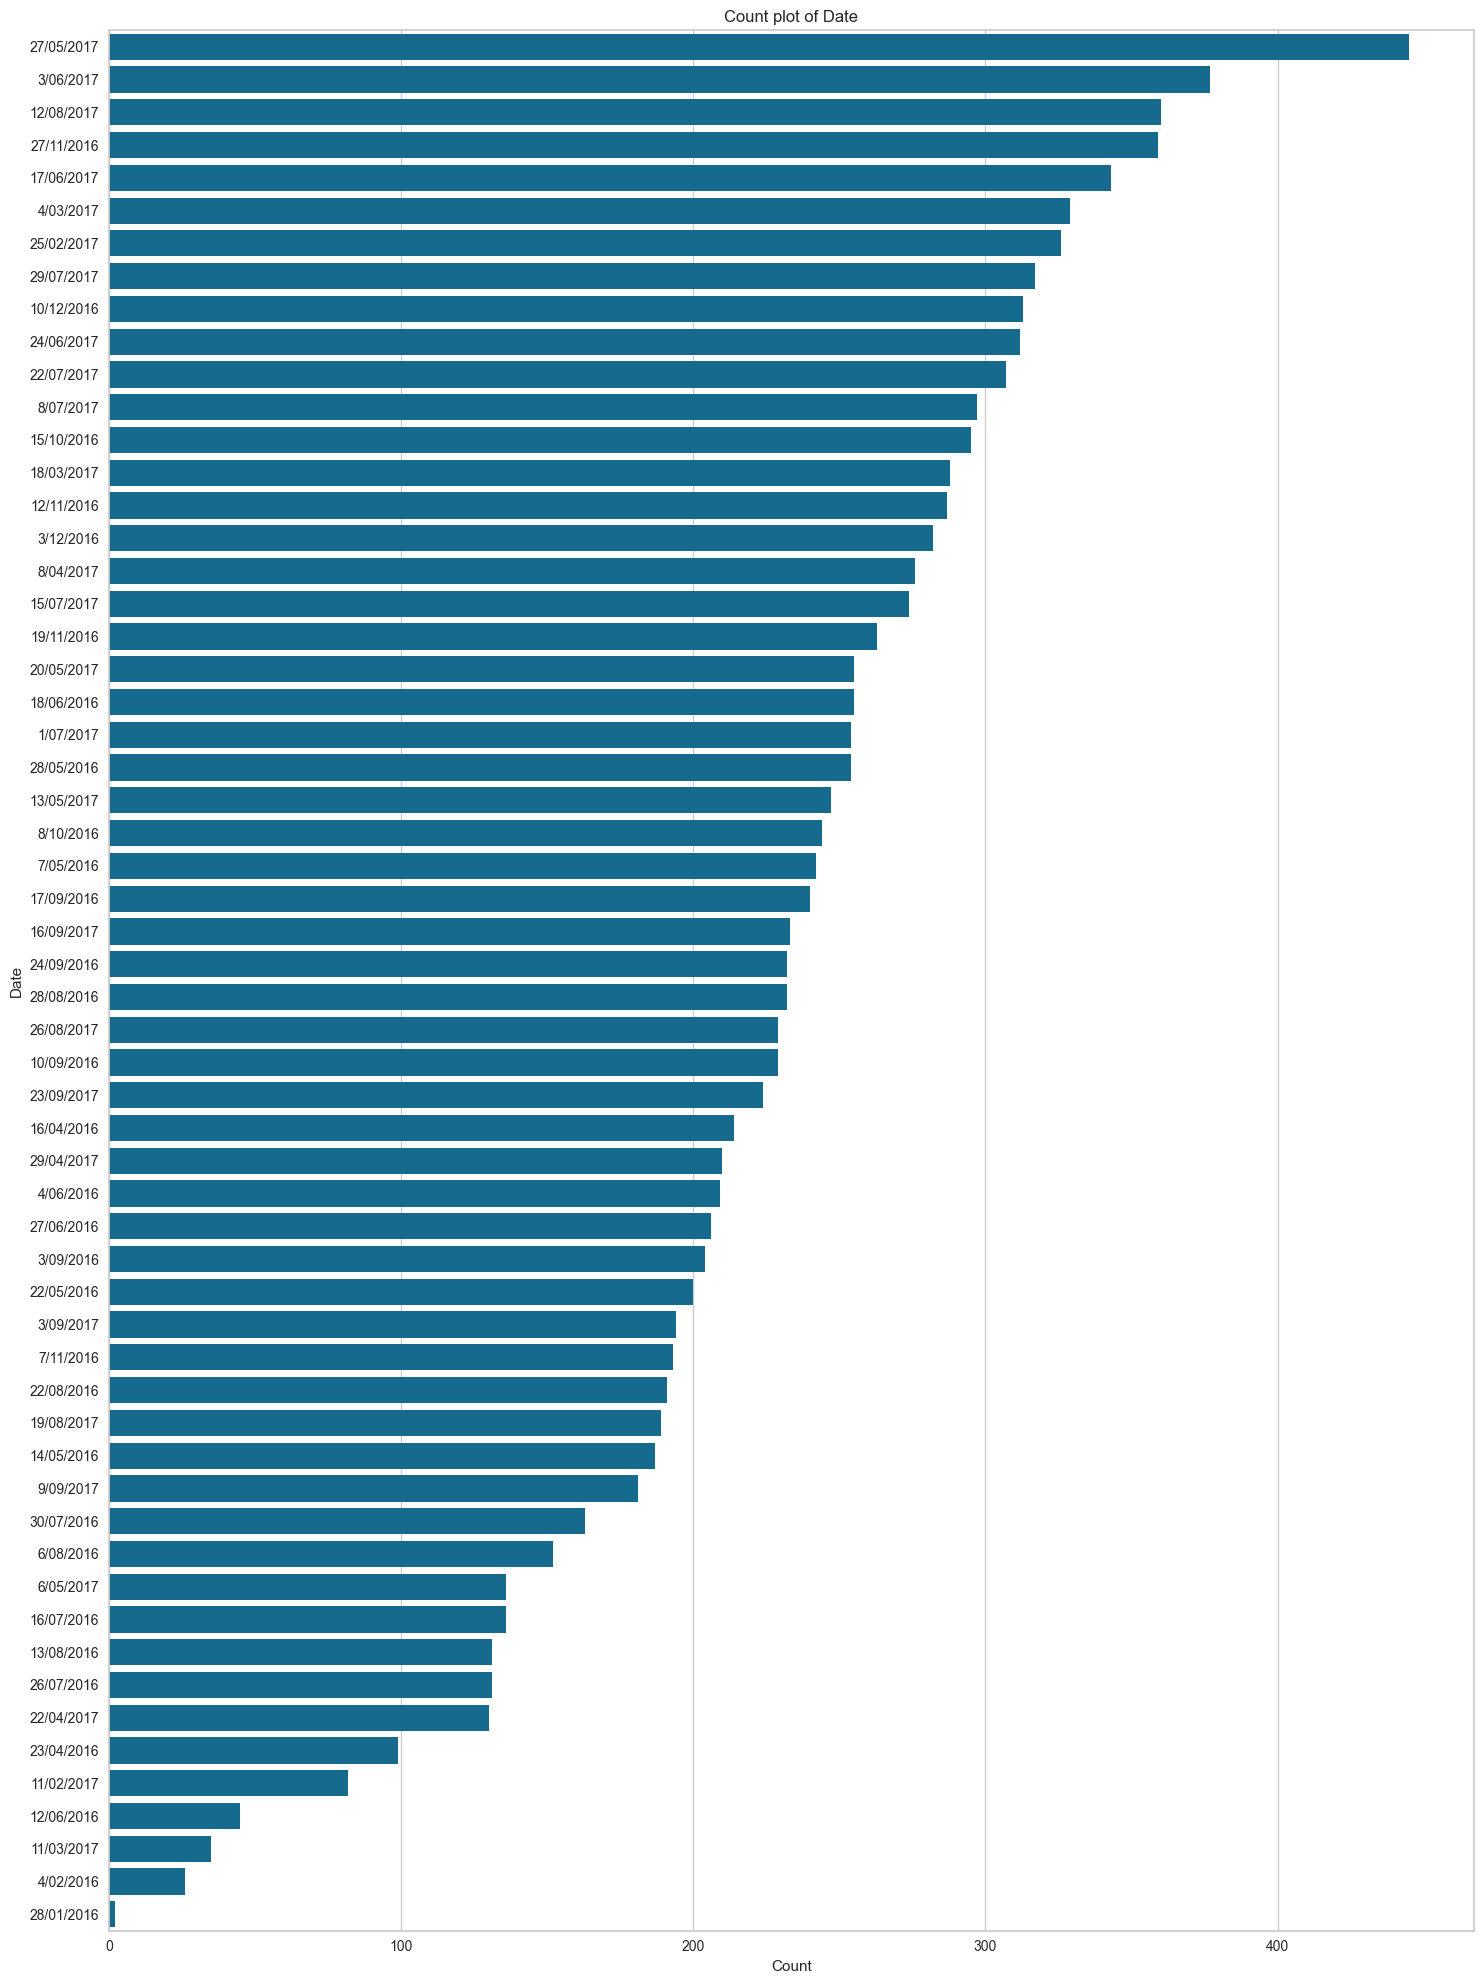

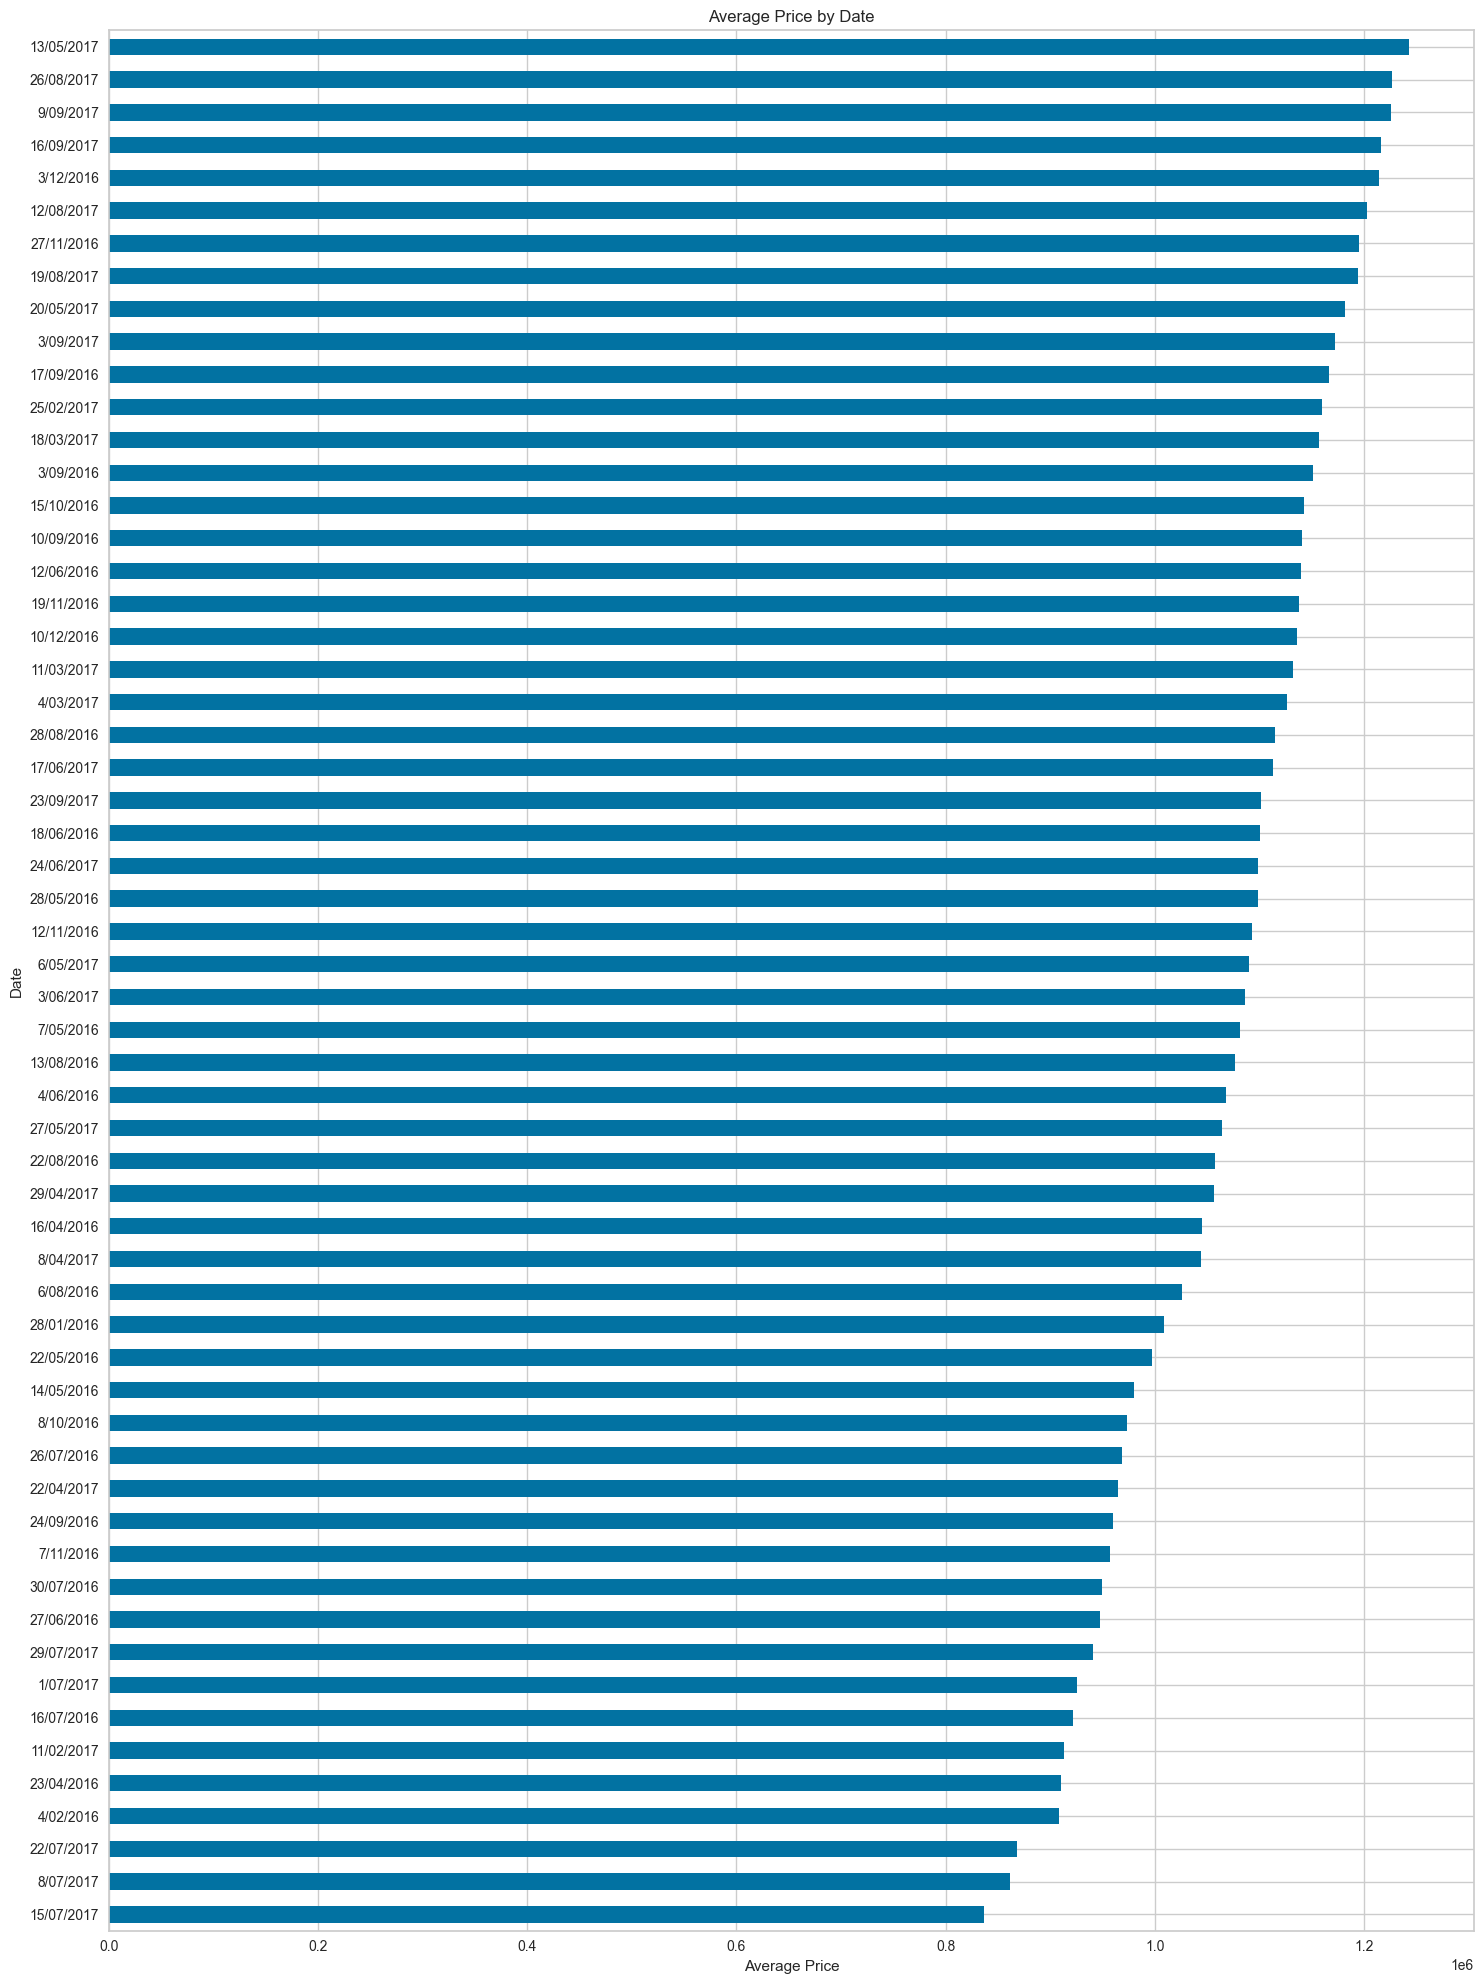

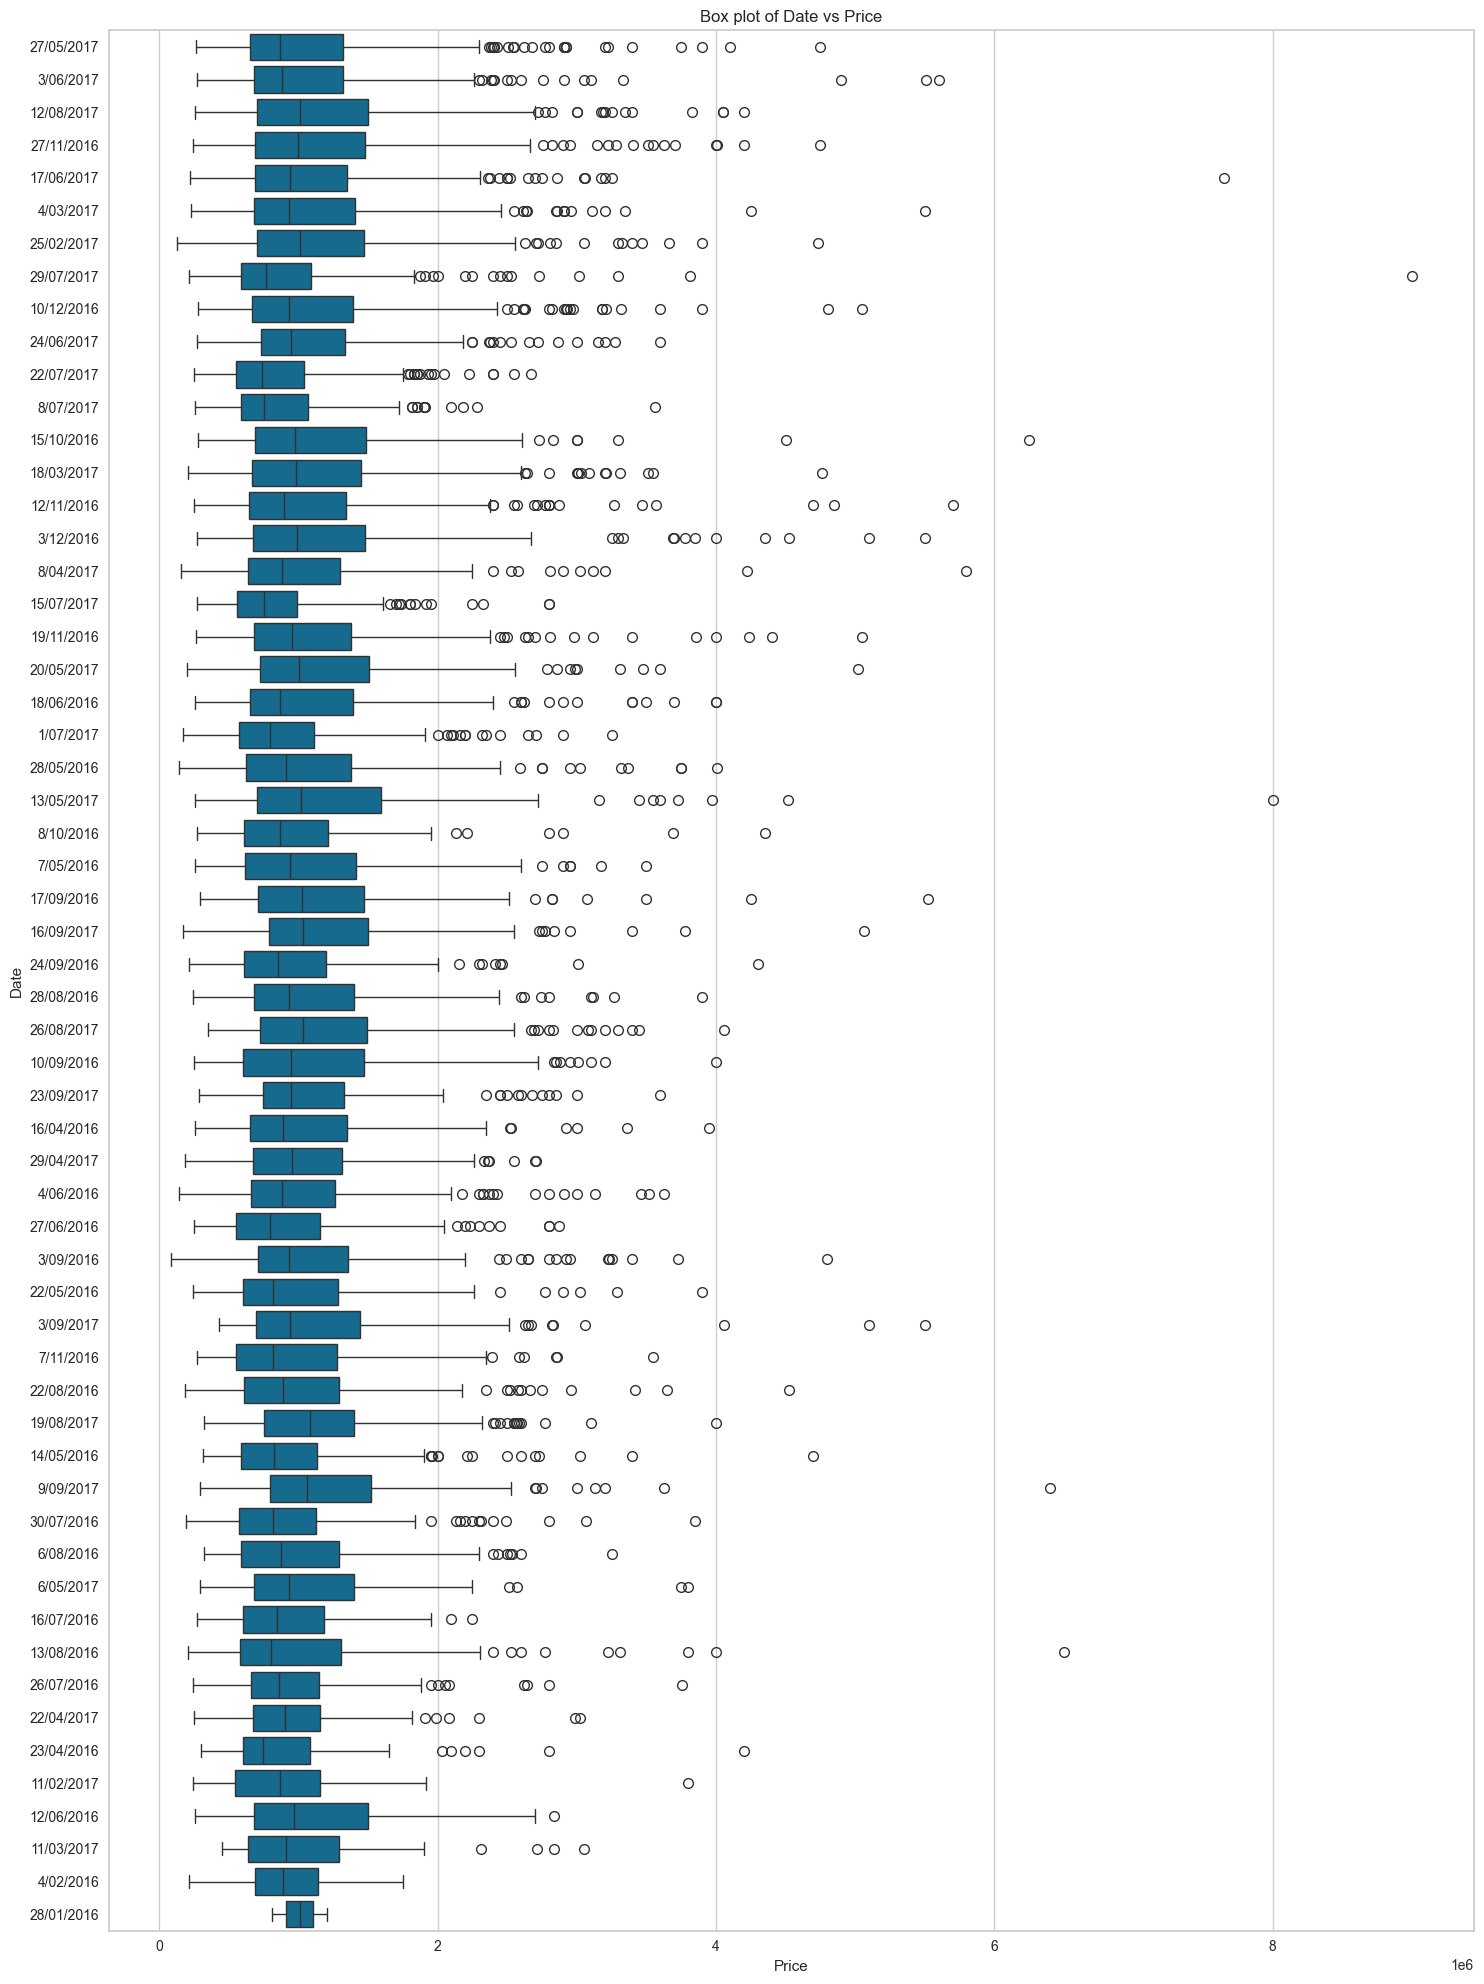

In [26]:
# Count plot for Date
plt.figure(figsize=(15, 20))
sb.countplot(data=housingdata, y='Date', order=housingdata['Date'].value_counts().index)
plt.title('Count plot of Date')
plt.xlabel('Count')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Average price bar plot for Date
# We'll compute the average price per Date and plot it
avg_price = housingdata.groupby('Date')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15, 20))
avg_price.plot(kind='barh')
plt.title('Average Price by Date')
plt.xlabel('Average Price')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Date
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='Date', x='Price', order=housingdata['Date'].value_counts().index)
plt.title('Box plot of Date vs Price')
plt.xlabel('Price')
plt.ylabel('Date')
plt.tight_layout()
plt.show()

##### Analysis of 'CouncilArea' Variable

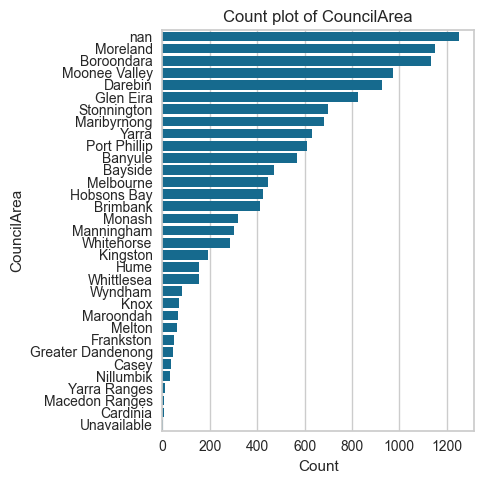

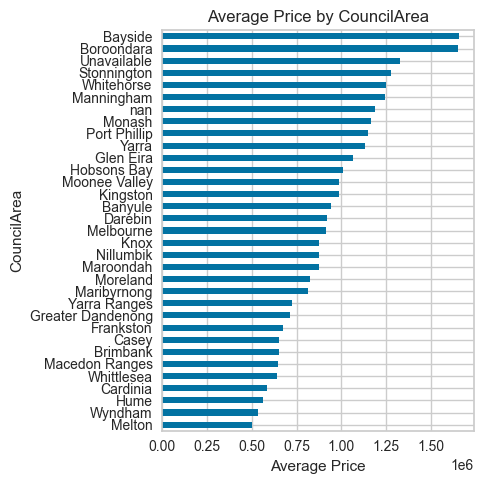

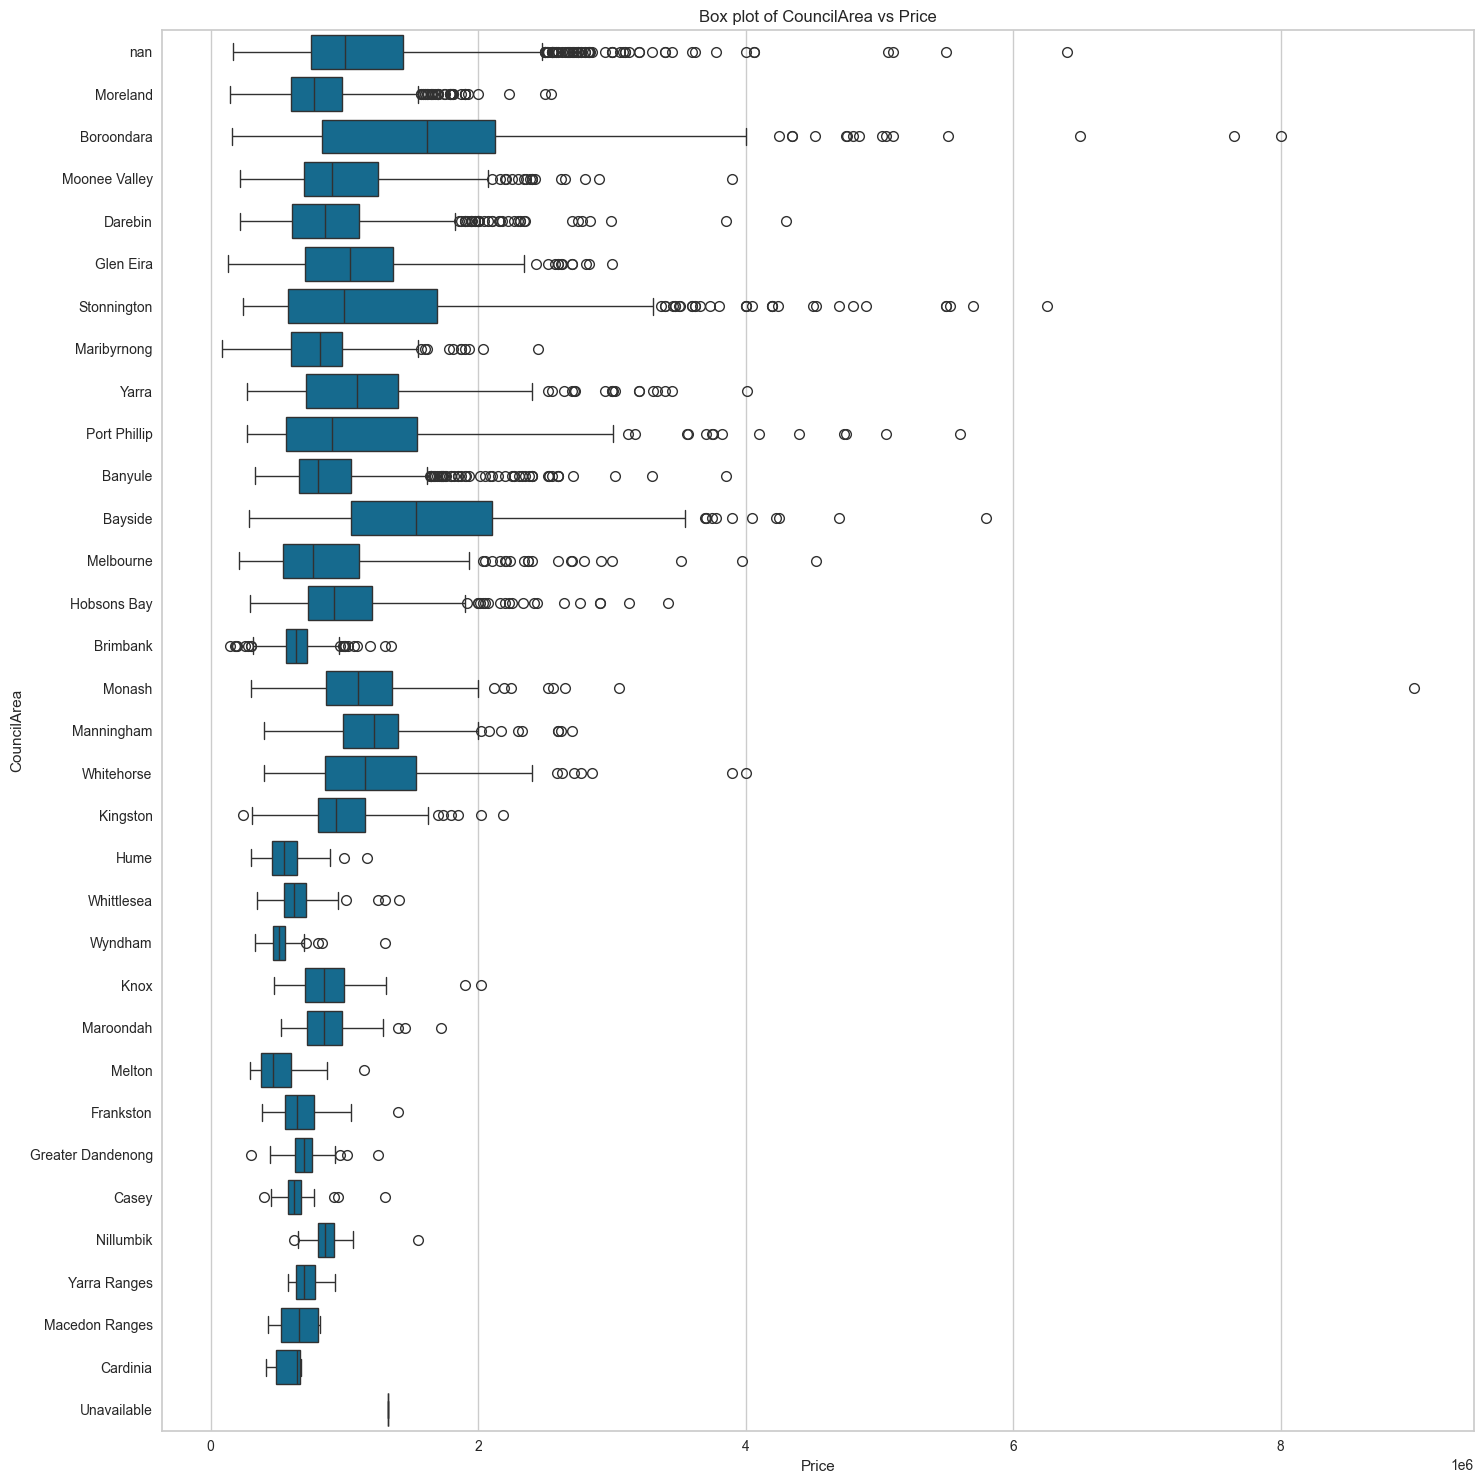

In [27]:
# Count plot for CouncilArea
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='CouncilArea', order=housingdata['CouncilArea'].value_counts().index)
plt.title('Count plot of CouncilArea')
plt.xlabel('Count')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

# Average price bar plot for CouncilArea
# We'll compute the average price per CouncilArea and plot it
avg_price = housingdata.groupby('CouncilArea')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by CouncilArea')
plt.xlabel('Average Price')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by CouncilArea
plt.figure(figsize=(15,15))
sb.boxplot(data=housingdata, y='CouncilArea', x='Price', order=housingdata['CouncilArea'].value_counts().index)
plt.title('Box plot of CouncilArea vs Price')
plt.xlabel('Price')
plt.ylabel('CouncilArea')
plt.tight_layout()
plt.show()

##### Analysis of 'Regionname' Variable

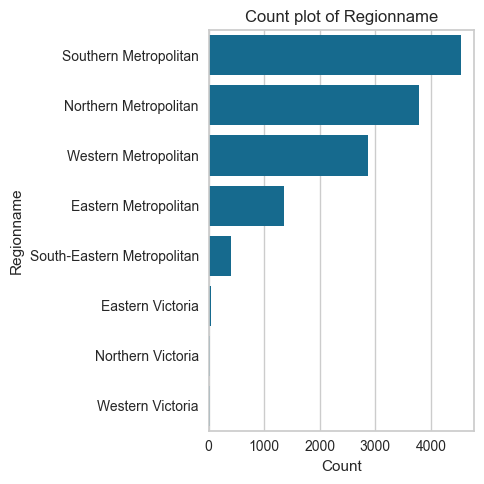

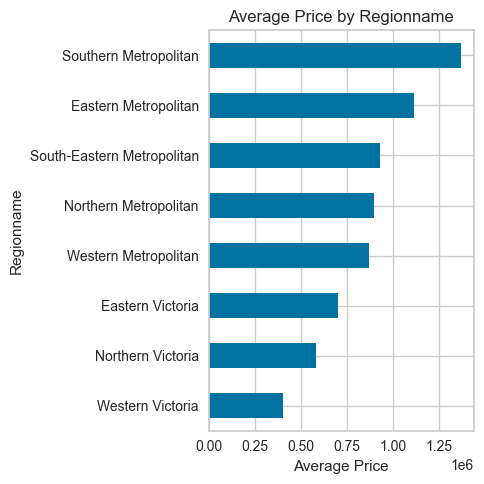

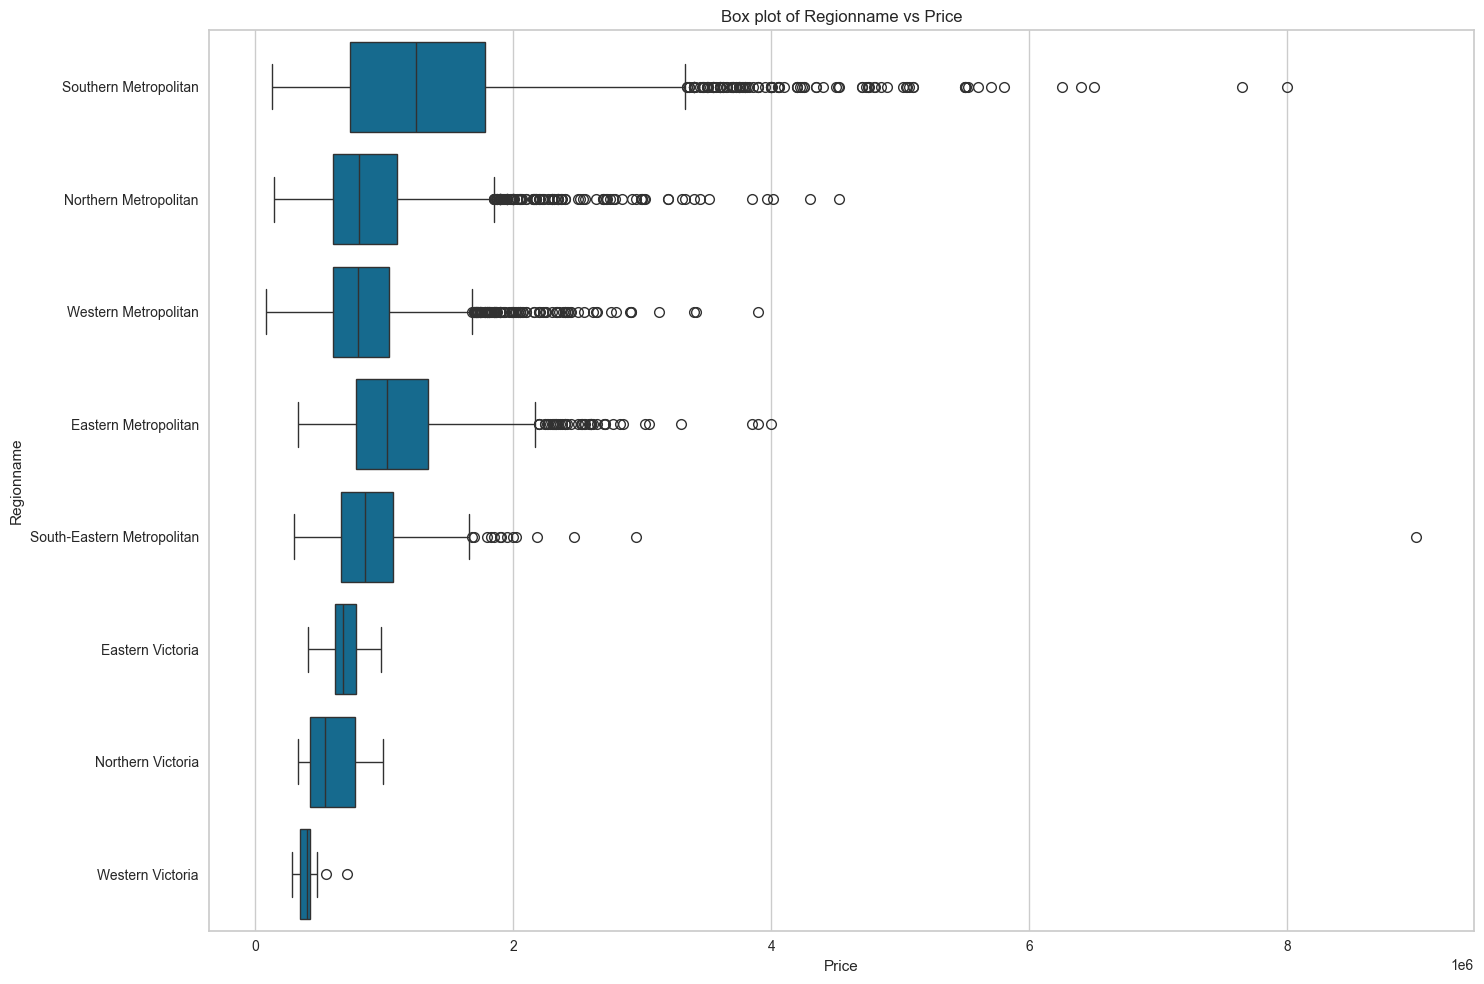

In [28]:
# Count plot for Regionname
plt.figure(figsize=(5,5))
sb.countplot(data=housingdata, y='Regionname', order=housingdata['Regionname'].value_counts().index)
plt.title('Count plot of Regionname')
plt.xlabel('Count')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

# Average price bar plot for Regionname
# We'll compute the average price per Regionname and plot it
avg_price = housingdata.groupby('Regionname')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(5,5))
avg_price.plot(kind='barh')
plt.title('Average Price by Regionname')
plt.xlabel('Average Price')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Regionname
plt.figure(figsize=(15,10))
sb.boxplot(data=housingdata, y='Regionname', x='Price', order=housingdata['Regionname'].value_counts().index)
plt.title('Box plot of Regionname vs Price')
plt.xlabel('Price')
plt.ylabel('Regionname')
plt.tight_layout()
plt.show()

In [29]:
# for col in categorical:
#     # Count plot for categorical features
#     plt.figure(figsize=(15,20))
#     sb.catplot(data=housingdata, y=col, kind='count')
#     plt.title(f'Count plot of {col}')
#     plt.show()
    
#     # Box plot for categorical features against numerical variables
#     plt.figure(figsize=(15,20))
#     sb.boxplot(x=housingdata[col], y=housingdata['Price'])
#     plt.title(f'Box plot of {col} vs Price')
#     plt.show()

## Preparation of Response & Predictor Variables
1. Dimensionality/Cardinality Reduction for Categorical Variables
2. Feature Engineering

### 1. Dimensionality/Cardinality Reduction for Categorical Variables
Some of the categorical variables in this dataset contain a large number of unique categories (high cardinality), contributing to a lot of unnecessary noise in our analysis and reduced interpretability. 

Hence we will perform dimensionality (cardinality) reduction on selected categorical features (Suburb, SellerG, and Address) by grouping less common categories into an 'Other' category. The threshold we will choose for this is a 1% (Will probs change) proportion; categories within a variable that make up less than 1% of the number of rows in the dataset will be all classified into an 'Other' category.

Define a function for grouping the less common categories:

In [30]:
def group_rare_categories(df, column, threshold=0.01):
    # Calculate category counts
    category_counts = df[column].value_counts(normalize=True)
    
    # Identify categories with frequency less than the threshold
    rare_categories = category_counts[category_counts < threshold].index
    
    # Replace rare categories with "Other"
    df[column] = df[column].apply(lambda x: 'Other' if x in rare_categories else x)
    
    return df

#### Dimensionality Reduction of Suburb

In [31]:
housingdata = group_rare_categories(housingdata, 'Suburb', threshold=0.01)

Let's check what Suburb looks like after dimensionality reduction.

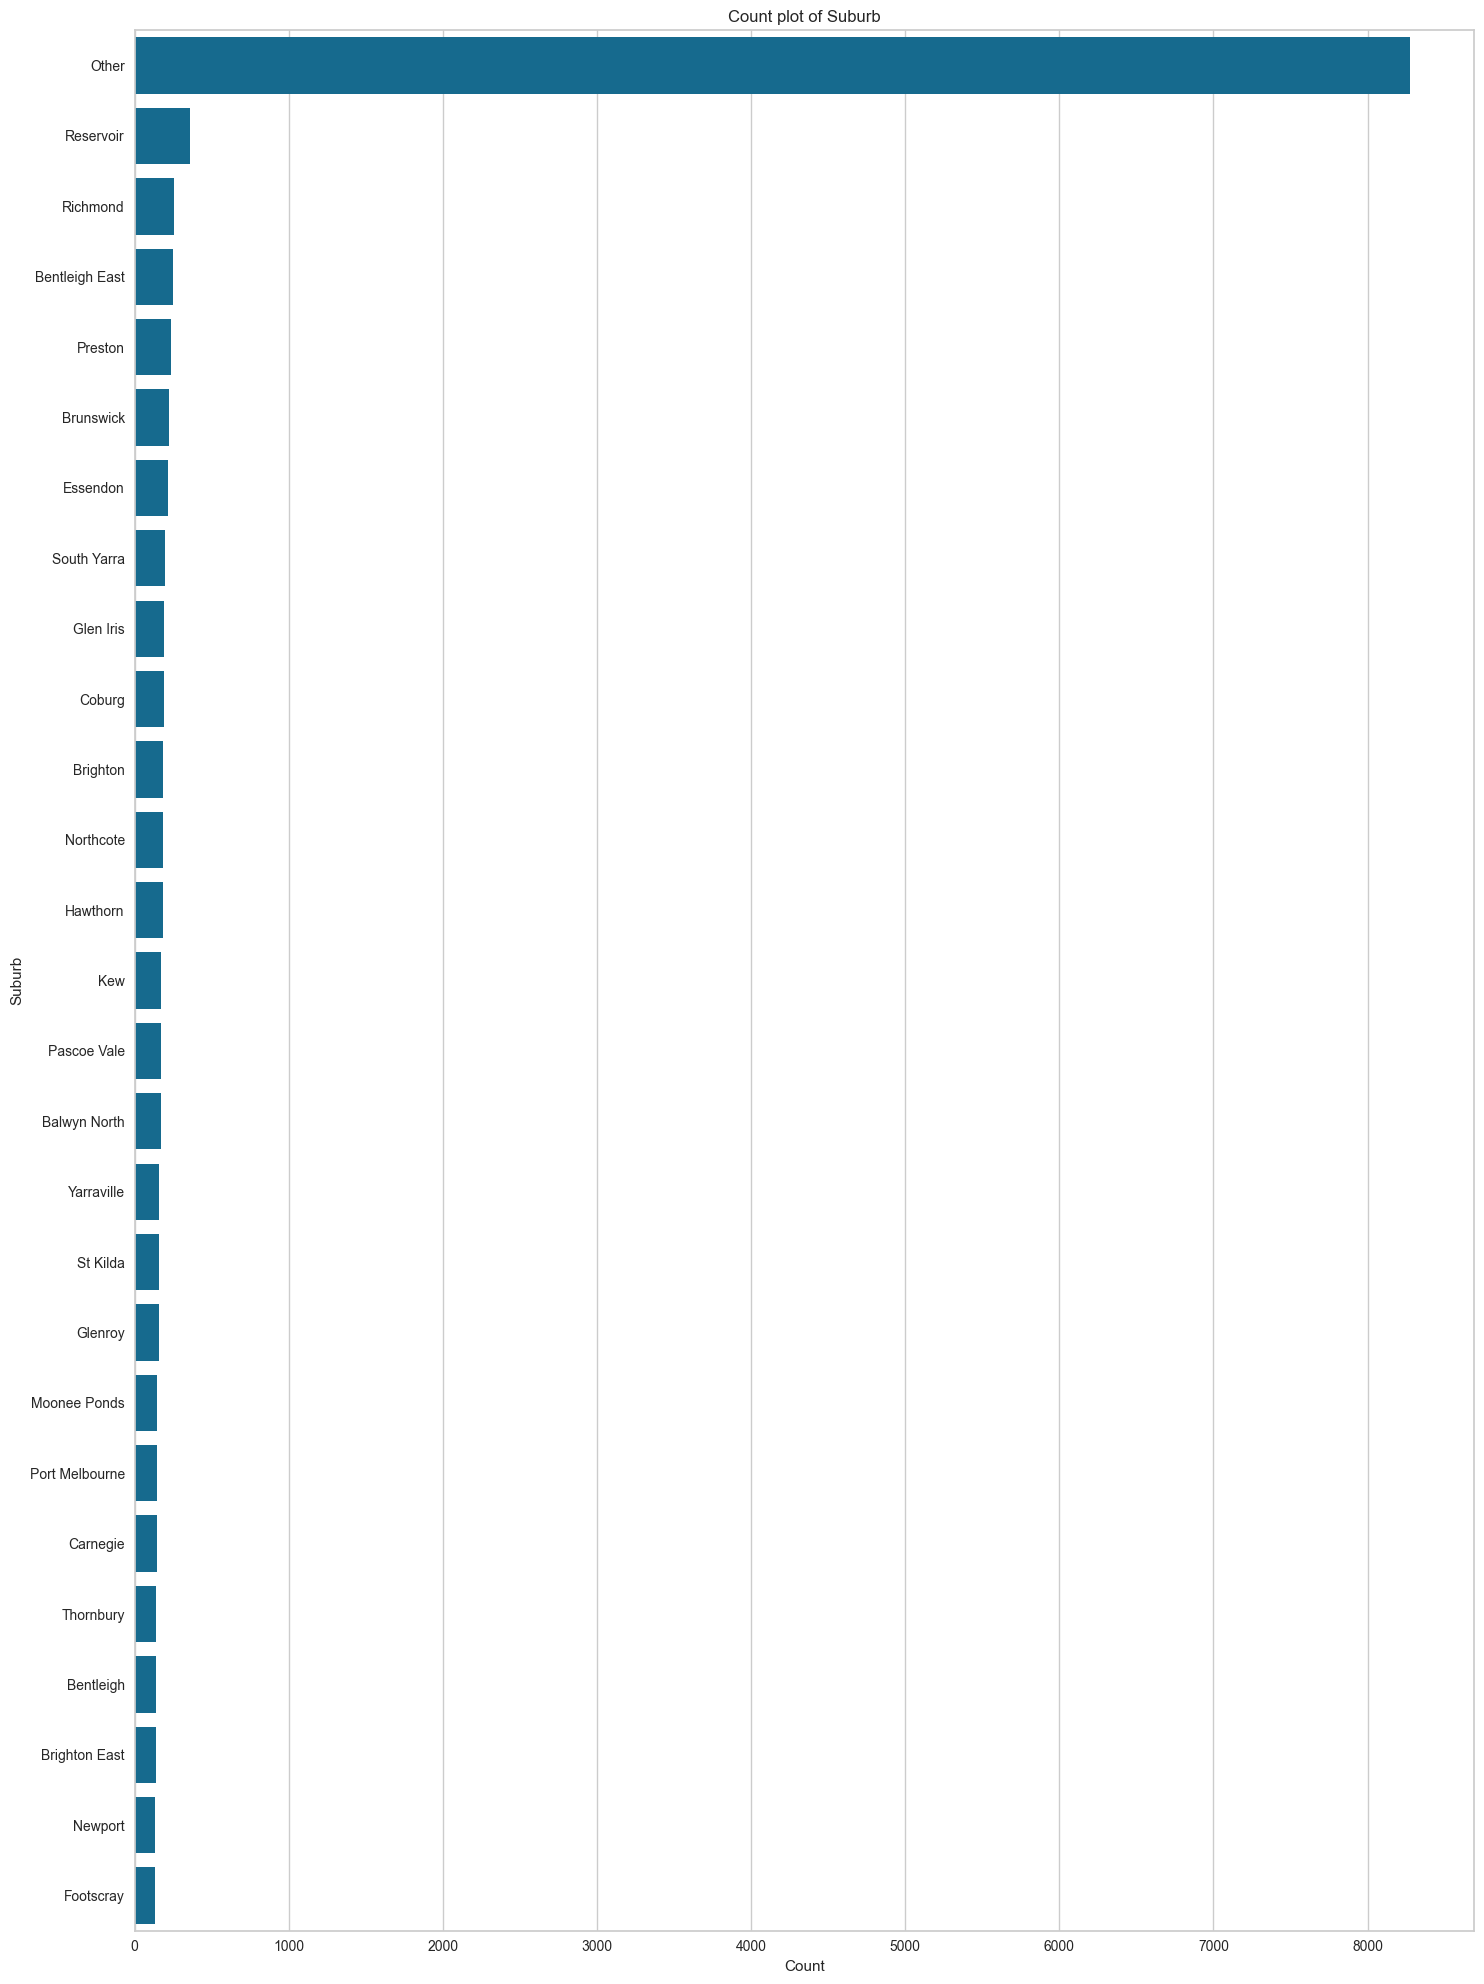

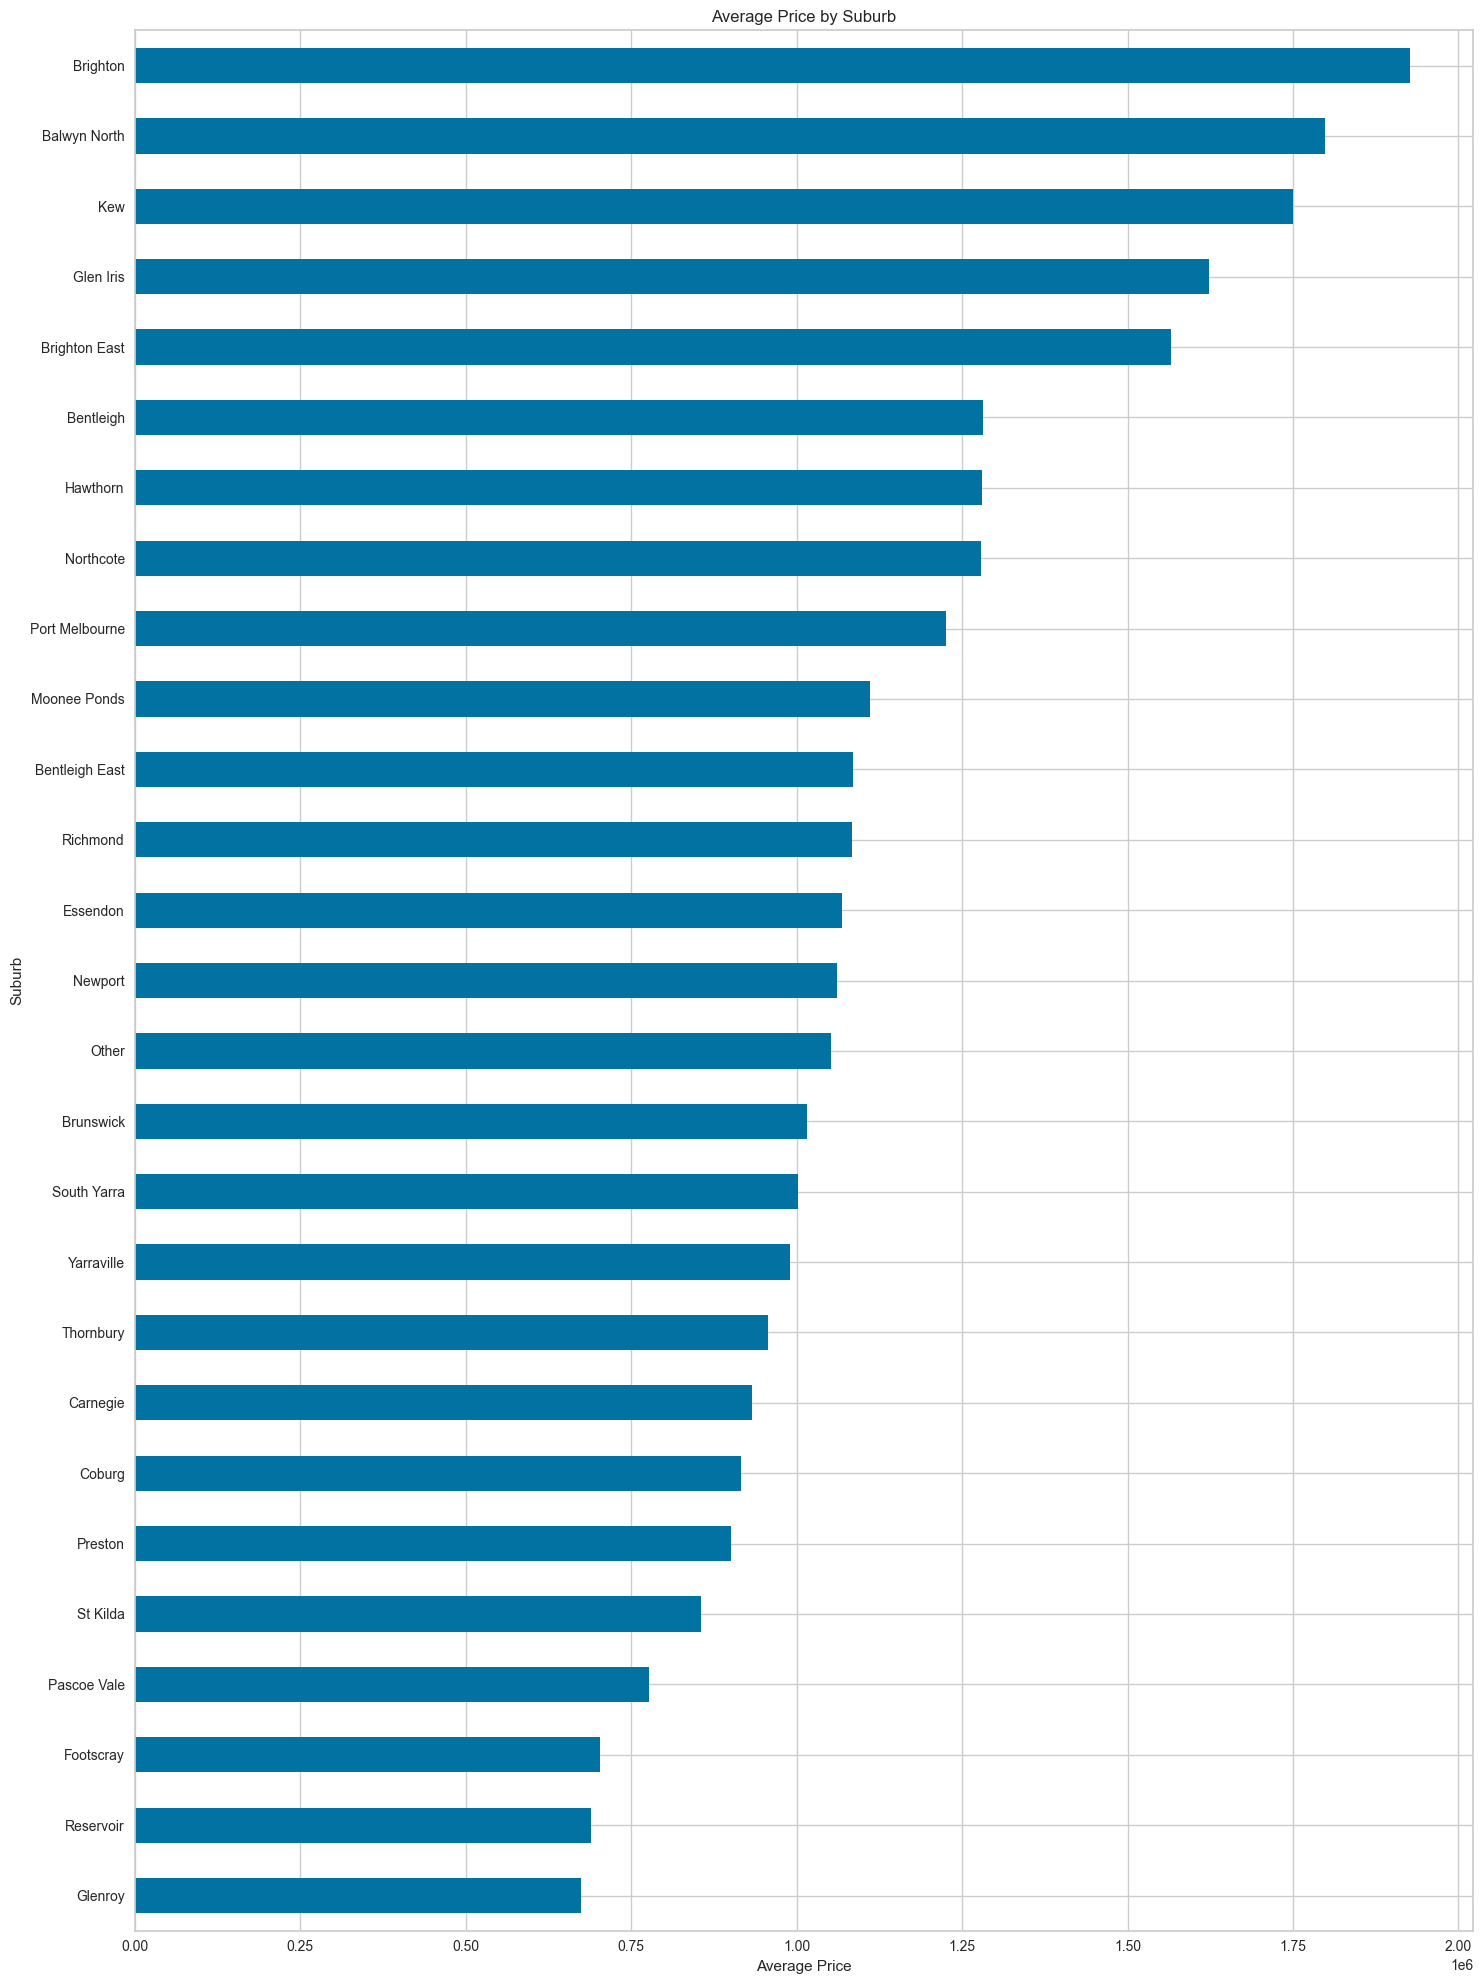

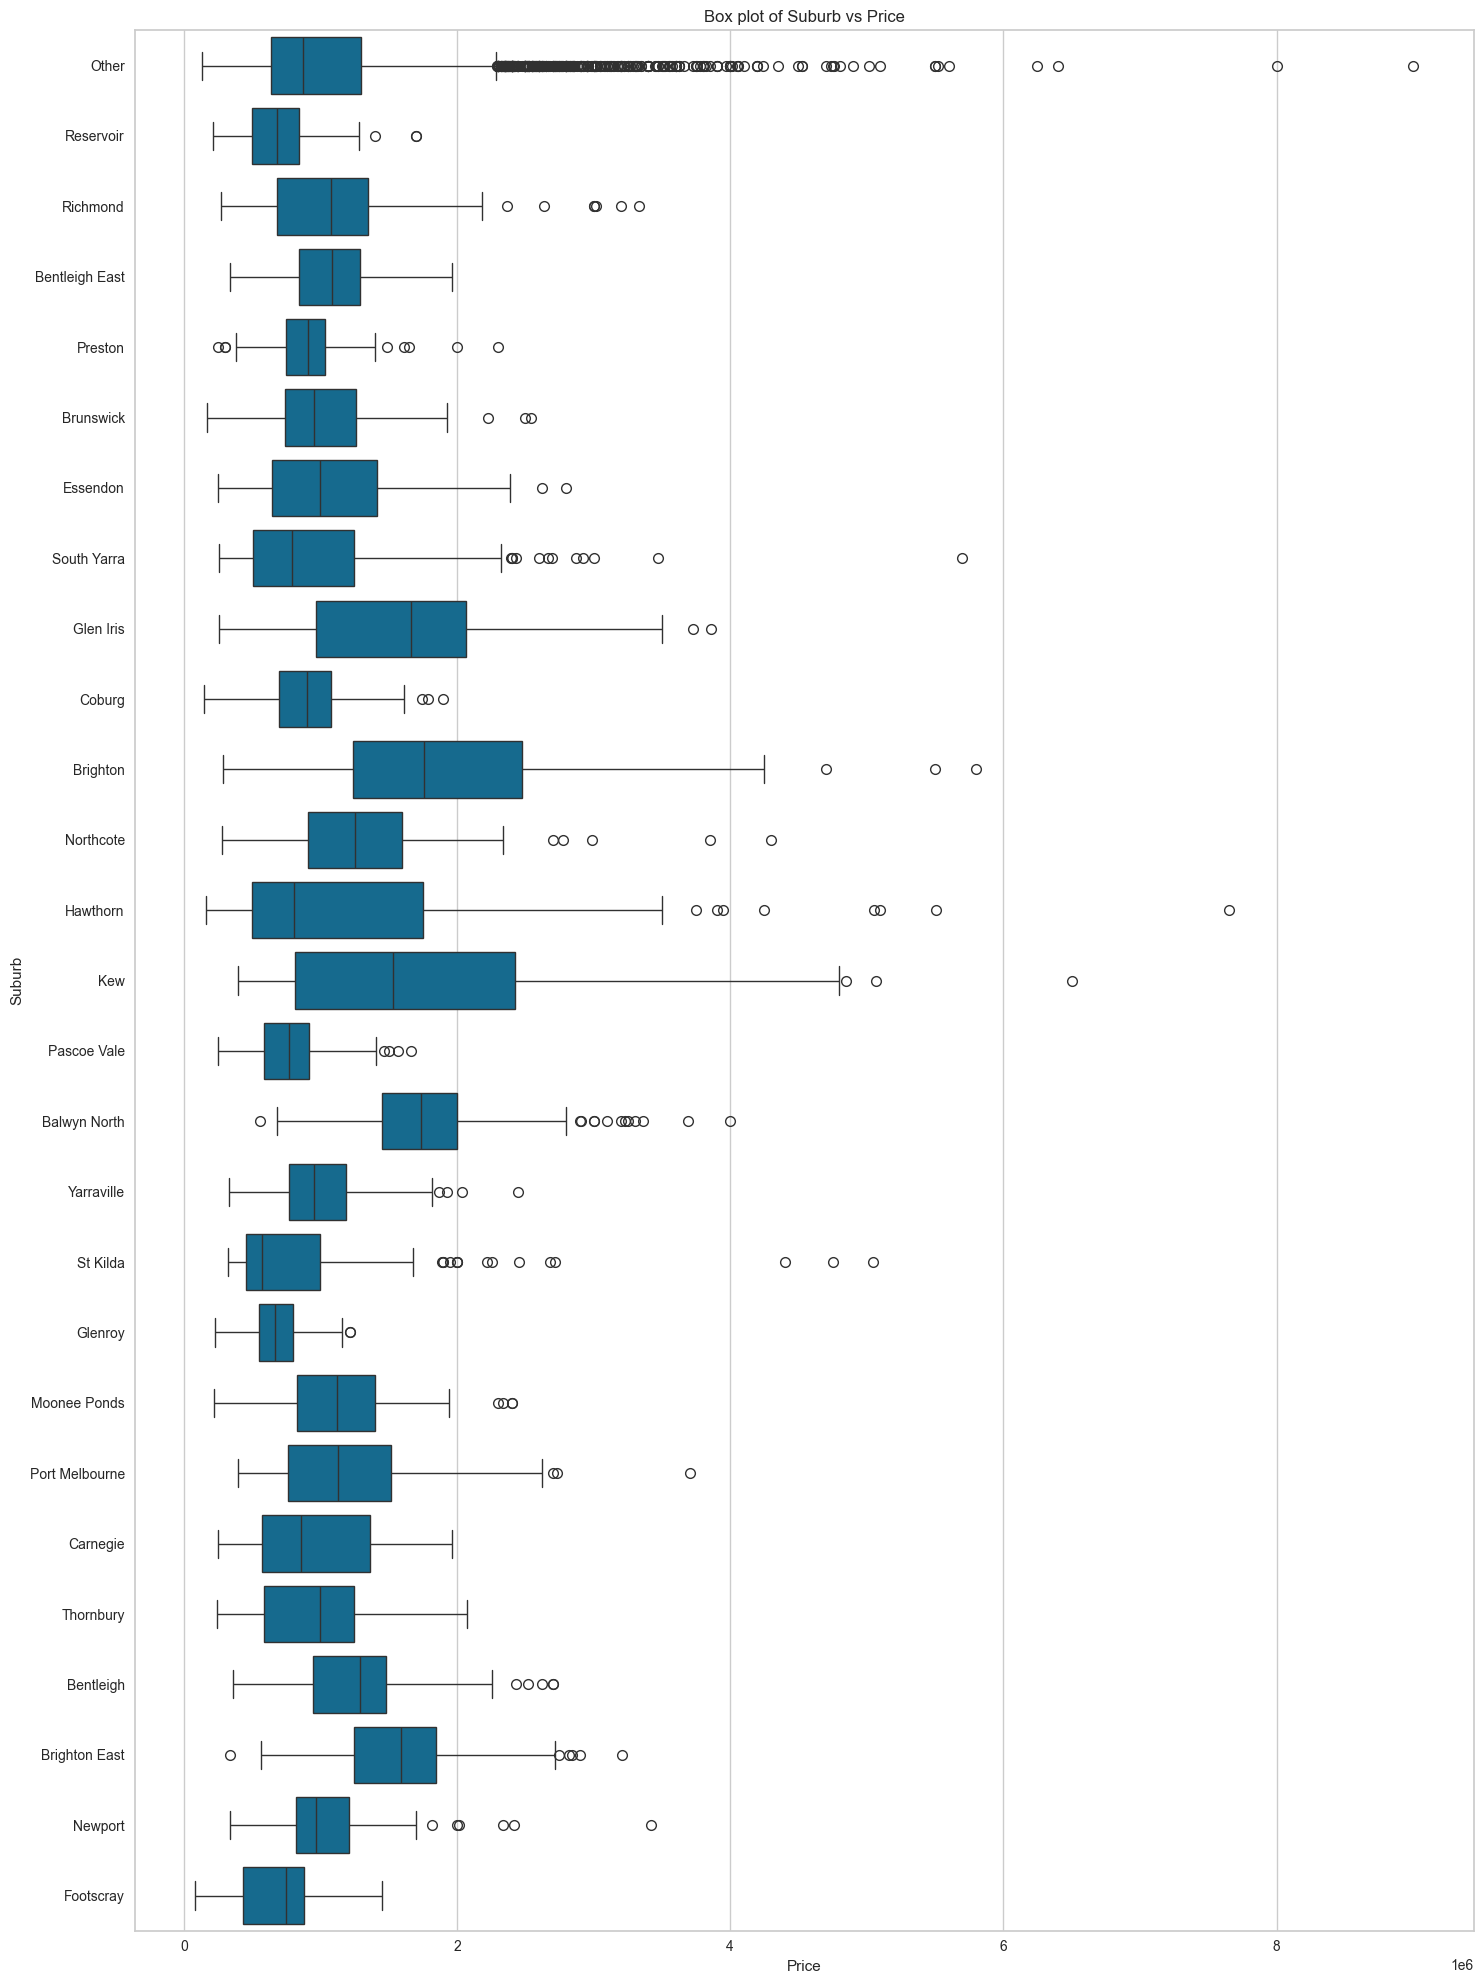

In [32]:
# Count plot for Suburb
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='Suburb', order=housingdata['Suburb'].value_counts().index)
plt.title('Count plot of Suburb')
plt.xlabel('Count')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Average price bar plot for Suburb
# We'll compute the average price per Suburb and plot it
avg_price = housingdata.groupby('Suburb')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by Suburb')
plt.xlabel('Average Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by Suburb
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='Suburb', x='Price', order=housingdata['Suburb'].value_counts().index)
plt.title('Box plot of Suburb vs Price')
plt.xlabel('Price')
plt.ylabel('Suburb')
plt.tight_layout()
plt.show()

#### Dimensionality Reduction of SellerG

In [33]:
housingdata = group_rare_categories(housingdata, 'SellerG', threshold=0.01)

Let's check what SellerG looks like after dimensionality reduction.

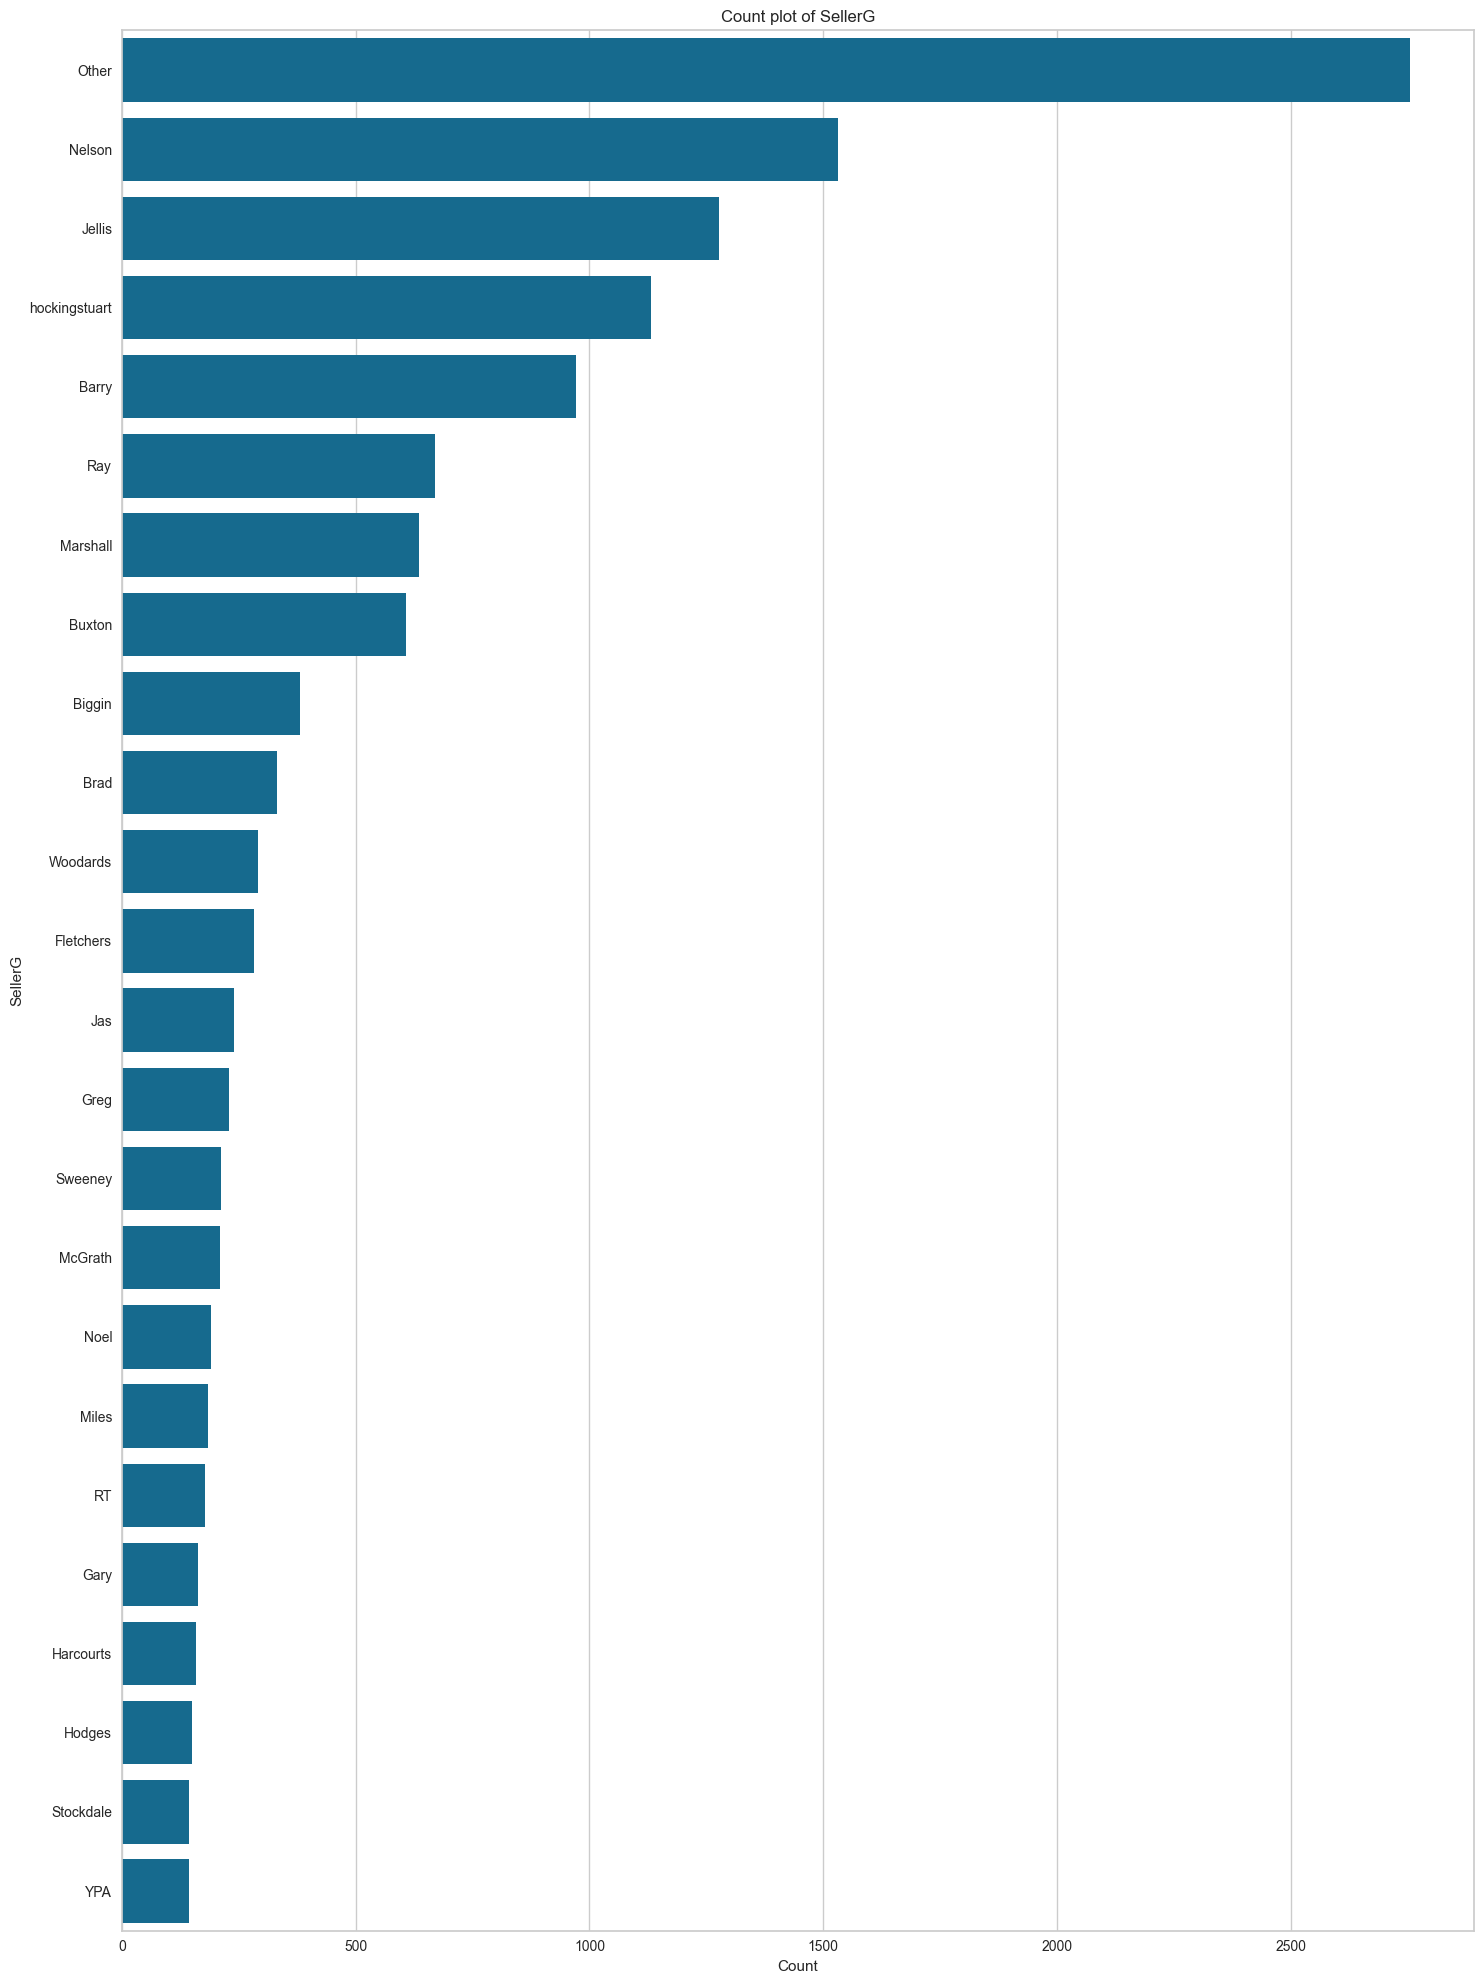

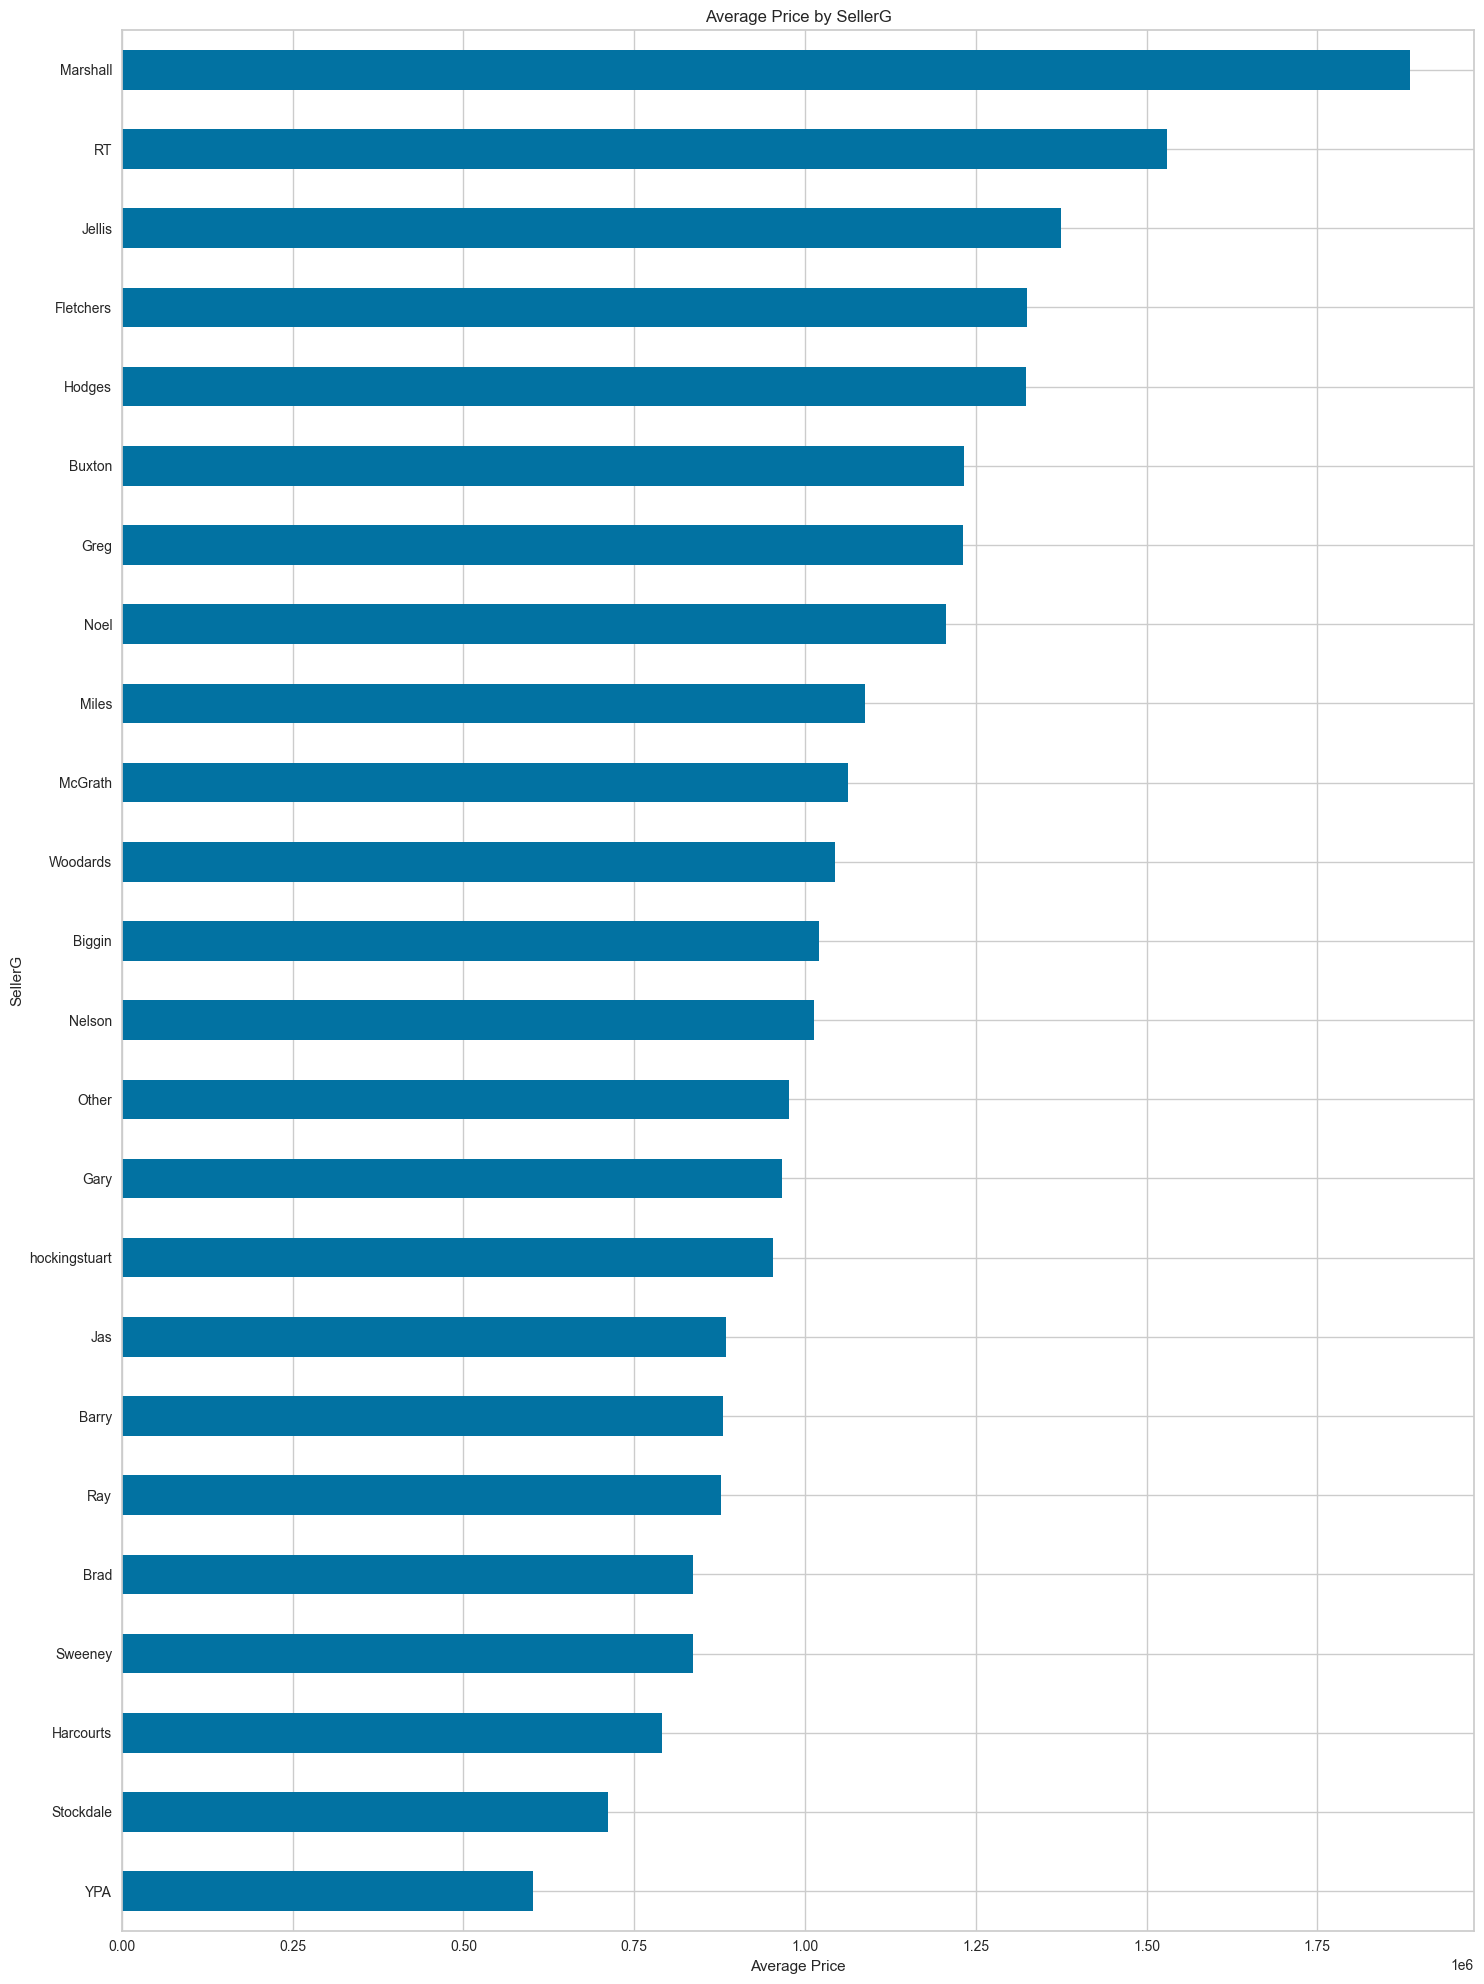

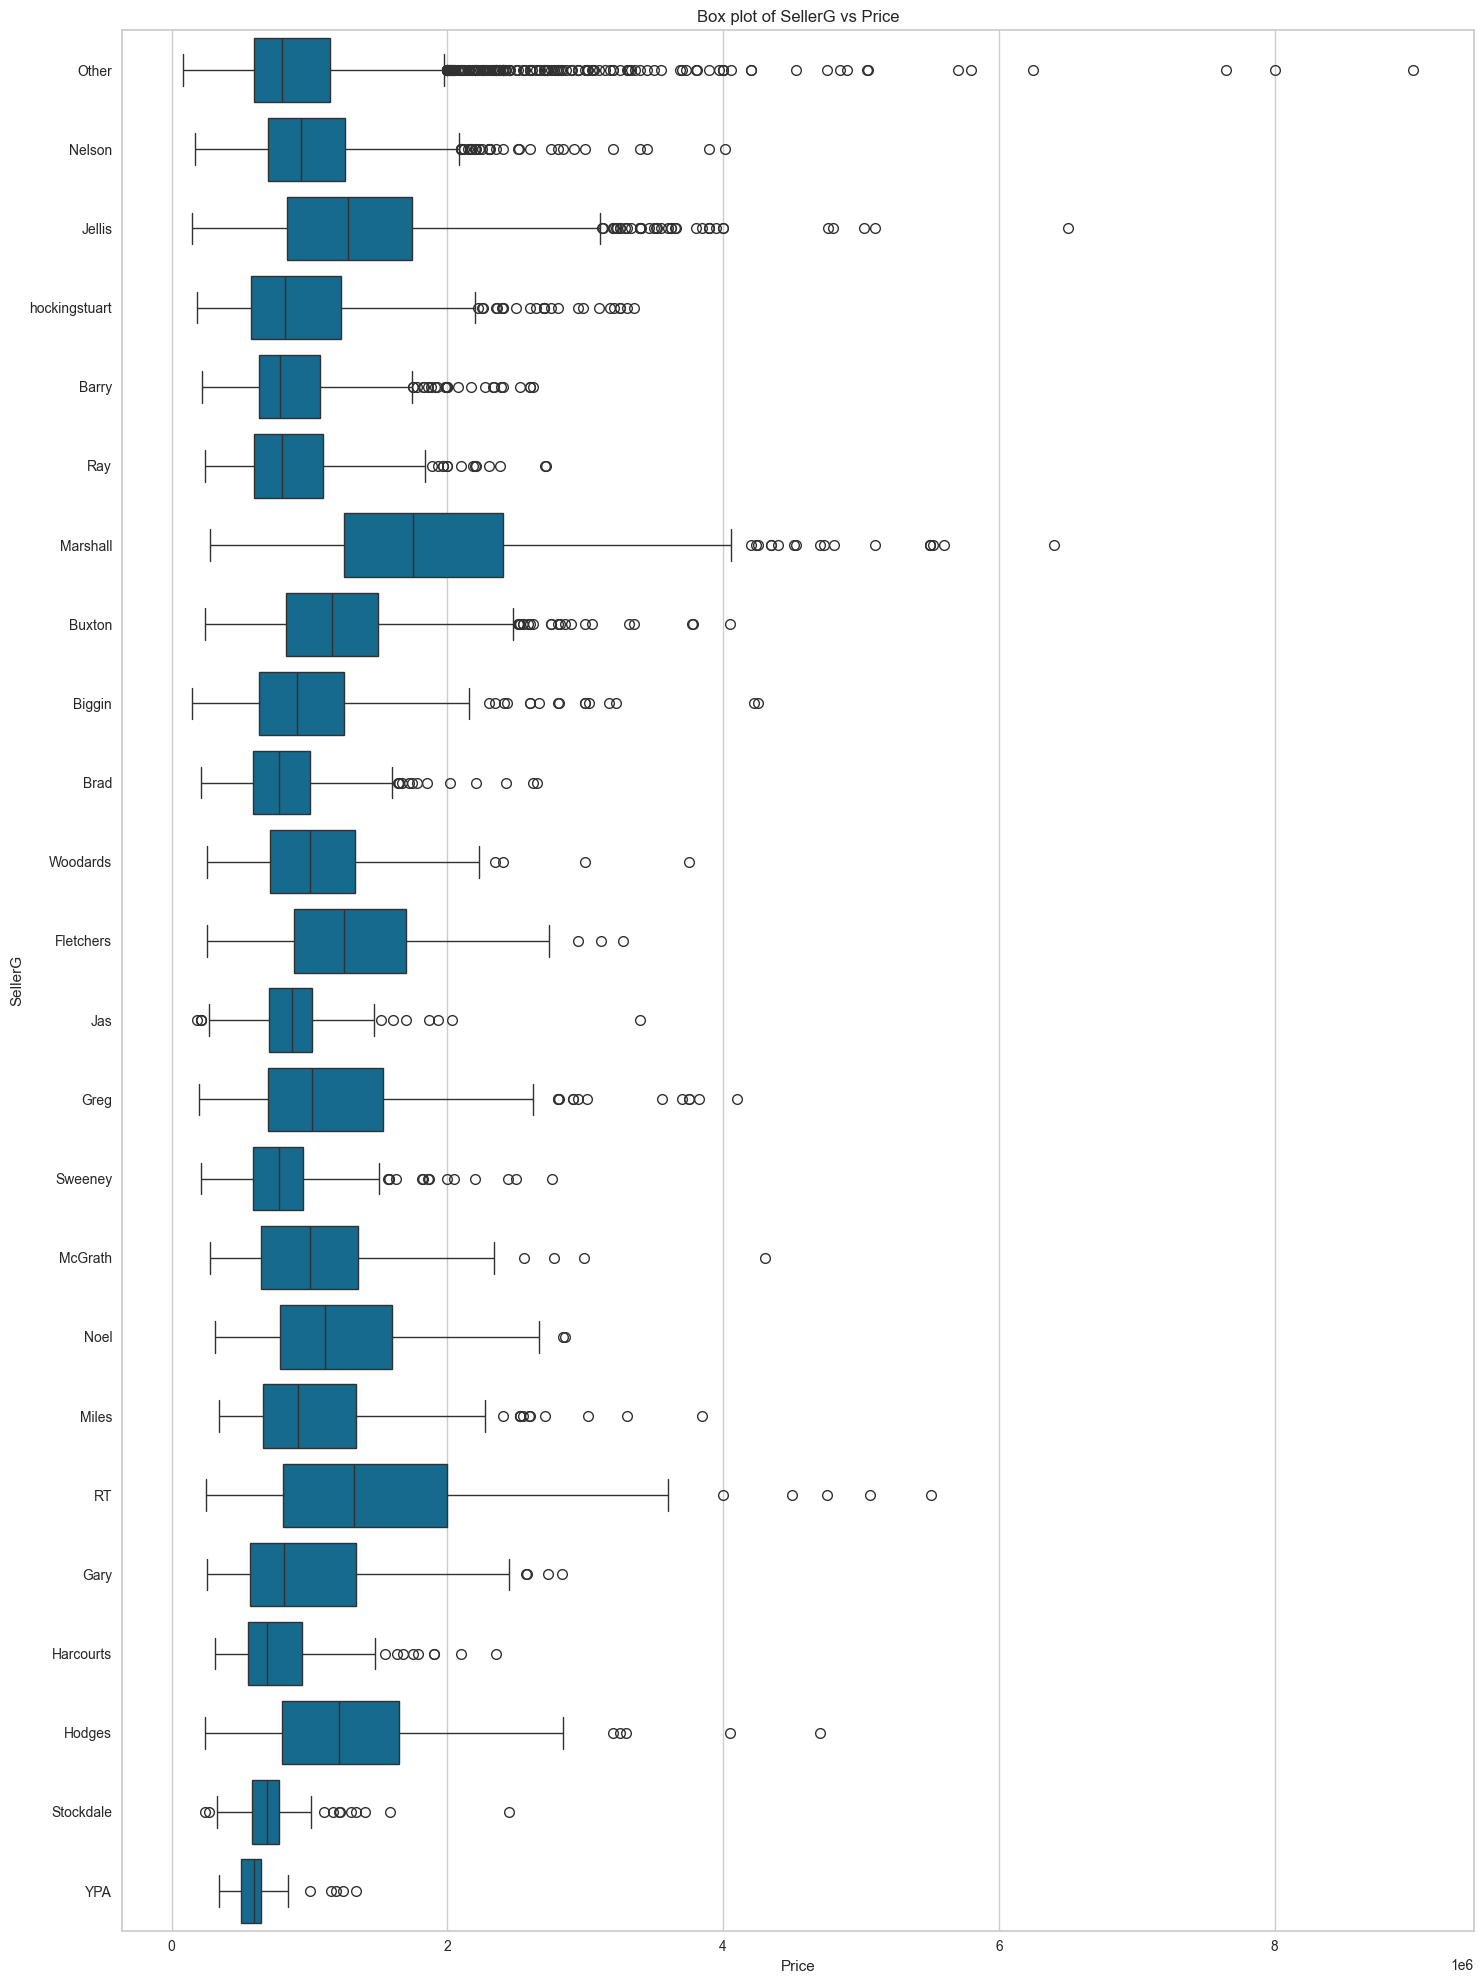

In [34]:
# Count plot for SellerG
plt.figure(figsize=(15,20))
sb.countplot(data=housingdata, y='SellerG', order=housingdata['SellerG'].value_counts().index)
plt.title('Count plot of SellerG')
plt.xlabel('Count')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Average price bar plot for SellerG
# We'll compute the average price per SellerG and plot it
avg_price = housingdata.groupby('SellerG')['Price'].mean().sort_values(ascending=True)

plt.figure(figsize=(15,20))
avg_price.plot(kind='barh')
plt.title('Average Price by SellerG')
plt.xlabel('Average Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

# Box plot of Price distribution by SellerG
plt.figure(figsize=(15,20))
sb.boxplot(data=housingdata, y='SellerG', x='Price', order=housingdata['SellerG'].value_counts().index)
plt.title('Box plot of SellerG vs Price')
plt.xlabel('Price')
plt.ylabel('SellerG')
plt.tight_layout()
plt.show()

#### Dimensionality Reduction of Address - Feature Elimination
We choose to drop 'Address' entirely as it is highly granular and provides little to no relevance in predicting house prices. Removing it contributes to reducing the overall dimensionality of the dataset.

In [35]:
housingdata = housingdata.drop(columns=['Address'])

### 2. Feature Engineering

#### Feature Engineering of 'Date' Variable
Since we are planning to use 'Date' as a time-based feature in trend analysis, we convert it from a string to datetime format and extract additional time-based features such as 'Year', 'Month', and 'YearMonth'. These derived variables will allow us to identify patterns across different regions over time.


In [41]:
# Convert 'Date' to datetime format
housingdata['Date'] = pd.to_datetime(housingdata['Date'], dayfirst=True)

# Create new time-based features
housingdata['Year'] = housingdata['Date'].dt.year
housingdata['Month'] = housingdata['Date'].dt.month
housingdata['YearMonth'] = housingdata['Date'].dt.to_period('M')

housingdata

Suburb  Rooms Type      Price Method  SellerG       Date  Distance  \
0           Other      2    h  1480000.0      S   Biggin 2016-12-03       2.5   
1           Other      2    h  1035000.0      S   Biggin 2016-02-04       2.5   
2           Other      3    h  1465000.0     SP   Biggin 2017-03-04       2.5   
3           Other      3    h   850000.0     PI   Biggin 2017-03-04       2.5   
4           Other      4    h  1600000.0     VB   Nelson 2016-06-04       2.5   
...           ...    ...  ...        ...    ...      ...        ...       ...   
13575       Other      4    h  1245000.0      S    Barry 2017-08-26      16.7   
13576       Other      3    h  1031000.0     SP    Other 2017-08-26       6.8   
13577       Other      3    h  1170000.0      S    Other 2017-08-26       6.8   
13578       Other      4    h  2500000.0     PI  Sweeney 2017-08-26       6.8   
13579  Yarraville      4    h  1285000.0     SP    Other 2017-08-26       6.3   

       Postcode  Bedroom2  ...  BuildingArea  YearBuilt  CouncilArea  \
0        3067.0       2.0  ...          94.0     1900.0        Yarra   
1        3067.0       2.0  ...          79.0     1900.0        Yarra   
2        3067.0       3.0  ...         150.0     1900.0        Yarra   
3        3067.0       3.0  ...         120.0     1900.0        Yarra   
4        3067.0       3.0  ...         142.0     2014.0        Yarra   
...         ...       ...  ...           ...        ...          ...   
13575    3150.0       4.0  ...         162.5     1981.0          nan   
13576    3016.0       3.0  ...         133.0     1995.0          nan   
13577    3016.0       3.0  ...         164.0     1997.0          nan   
13578    3016.0       4.0  ...         157.0     1920.0          nan   
13579    3013.0       4.0  ...         112.0     1920.0          nan   

       Lattitude  Longtitude                  Regionname  Propertycount  Year  \
0      -37.79960   144.99840       Northern Metropolitan         4019.0  2016   
1      -37.80790   144.99340       Northern Metropolitan         4019.0  2016   
2      -37.80930   144.99440       Northern Metropolitan         4019.0  2017   
3      -37.79690   144.99690       Northern Metropolitan         4019.0  2017   
4      -37.80720   144.99410       Northern Metropolitan         4019.0  2016   
...          ...         ...                         ...            ...   ...   
13575  -37.90562   145.16761  South-Eastern Metropolitan         7392.0  2017   
13576  -37.85927   144.87904        Western Metropolitan         6380.0  2017   
13577  -37.85274   144.88738        Western Metropolitan         6380.0  2017   
13578  -37.85908   144.89299        Western Metropolitan         6380.0  2017   
13579  -37.81188   144.88449        Western Metropolitan         6543.0  2017   

      Month  YearMonth  
0        12    2016-12  
1         2    2016-02  
2         3    2017-03  
3         3    2017-03  
4         6    2016-06  
...     ...        ...  
13575     8    2017-08  
13576     8    2017-08  
13577     8    2017-08  
13578     8    2017-08  
13579     8    2017-08  

[13066 rows x 23 columns]

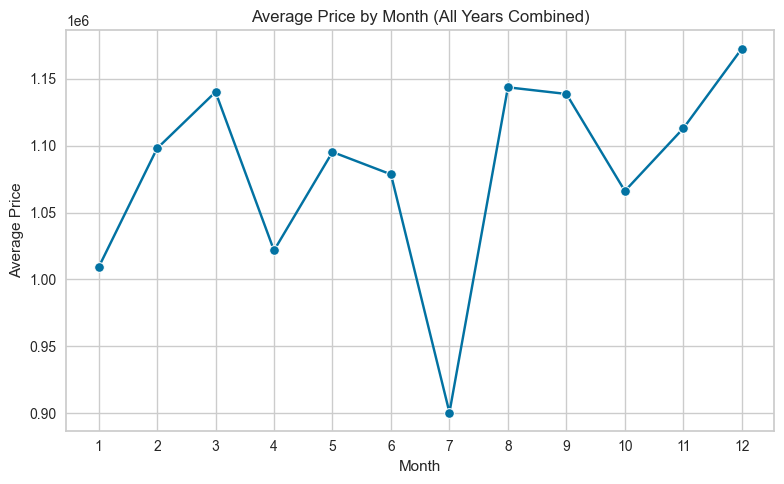

In [42]:
monthly_avg = housingdata.groupby("Month")["Price"].mean().reset_index()

plt.figure(figsize=(8, 5))
sb.lineplot(data=monthly_avg, x="Month", y="Price", marker="o")
plt.title("Average Price by Month (All Years Combined)")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()

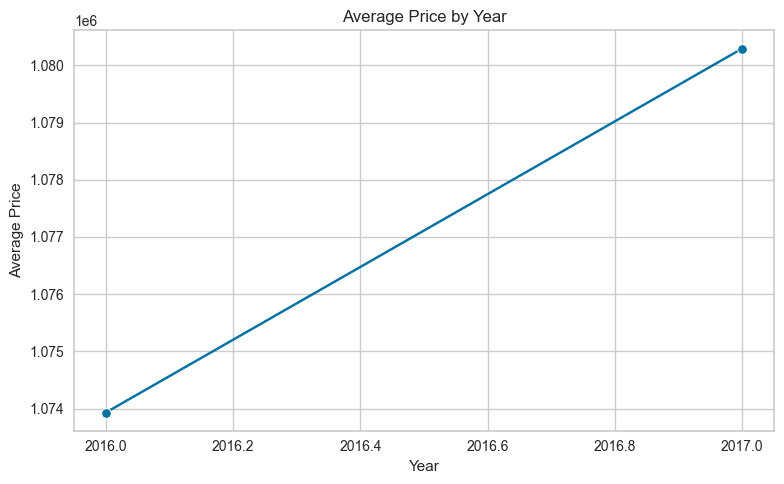

In [43]:
yearly_avg = housingdata.groupby("Year")["Price"].mean().reset_index()

plt.figure(figsize=(8, 5))
sb.lineplot(data=yearly_avg, x="Year", y="Price", marker="o")
plt.title("Average Price by Year")
plt.xlabel("Year")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()
